In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # suppress RuntimeWarning

# Section 1: NUTS algorithm in terms of classes

We rewrite our previous codes of NUTS into classes to make it more compact and easy to use.

In [3]:
class naiveNUTS:
    """
    Naive No-U-Turn Sampler (NUTS) implementation as a class.
    """
    
    def __init__(self, log_joint_density, grad_log_joint_density, M=None):
        """
        Initialise the NUTS sampler.
        
        Args:
            log_joint_density (callable): Function to compute the log joint density.
            grad_log_joint_density (callable): Function to compute the gradient of log joint density.
            M (np.ndarray, optional): The mass matrix. Defaults to identity matrix.
        """
        self.log_joint_density = log_joint_density
        self.grad_log_joint_density = grad_log_joint_density
        self.M = M
        

    def state_energy(self, theta, r, M=None):
        """
        Compute the Hamiltonian energy for a given state, including the KE and PE.
        
        Args:
            theta (np.ndarray): The parameter position vector.
            r (np.ndarray): The latent momentum vector.
            M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            
        Returns:
            tuple: (kinetic_energy, potential_energy, hamiltonian_energy)
        """
        if M is None:
            M = self.M
        
        # Compute the inverse of the mass matrix
        M_inv = np.linalg.inv(M)
        
        # Compute the kinetic energy in terms of momentum and inverse mass matrix
        kinetic_energy = 0.5 * r.T @ M_inv @ r
        # Compute the potential energy from the negative log joint density
        potential_energy = -self.log_joint_density(theta)
        
        # Total energy is the sum of kinetic and potential energies
        hamiltonian_energy = kinetic_energy + potential_energy
        
        return kinetic_energy, potential_energy, hamiltonian_energy
    

    def leapfrog(self, theta, r, v, M=None, eps=0.1):
        """
        Performs a single leapfrog integration step.
        
        Args:
            theta (np.ndarray): Current position vector.
            r (np.ndarray): Current momentum vector, as a latent variable.
            v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
            M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            eps (float): Stepsize for the leapfrog integration (set to be same with the NUTS stepsize). Default is 0.1.
            
        Returns:
            tuple: Updated position and momentum vectors.
        """
        if M is None:
            M = self.M
            
        M_inv = np.linalg.inv(M)
        
        # Half momentum update
        r_half = r + 0.5 * eps * v * self.grad_log_joint_density(theta)
        
        # Full position update
        theta_full = theta + v * eps * (M_inv @ r_half)
        
        # Half momentum update
        r_full = r_half + 0.5 * eps * v * self.grad_log_joint_density(theta_full)
        
        return theta_full, r_full
    

    def build_tree(self, theta, r, log_u, v, j, M=None, eps=0.1, delta_max=1000):
        """
        Recursively builds a binary tree of height-j for the naive NUTS algorithm,
        so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

        Args:
            theta (np.ndarray): Current position vector.
            r (np.ndarray): Current momentum vector, as a latent variable.
            log_u (float): Log slice variable, log-value for avoiding overflow.
            v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
            j (int): Current height/depth of the tree (start from 0).
            M (np.ndarray, optional): M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            eps (float): Stepsize for the leapfrog integration. Default is 0.1.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
        Returns:
            tuple: Leftmost position-momentum pair, rightmost position-momentum pair, 
                   accepted state/sample set (list) C, stop indicator s (by both U-turn condition and energy condition).
    """
        if M is None:
            M = self.M
            
        # Base case: when we start our tree with height 0
        if j == 0:
            # Take one leapfrog step in the direction v
            theta_prime, r_prime = self.leapfrog(theta, r, v, M, eps)
            
            # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
            # whether or not we should accept this new position-momentum pair in C_prime
            _, _, hamiltonian_energy = self.state_energy(theta_prime, r_prime, M)
            if log_u <= -hamiltonian_energy:
                C_prime = [(theta_prime, r_prime)]  # Accepted set C contains the new state
            else:
                C_prime = []  # No accepted state (empty set/list)
            
            # Check if we should stop (energy condition), compute the stop indicator s
            s_prime = int(log_u - delta_max < -hamiltonian_energy)
            
            # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
            # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
            return theta_prime, r_prime, theta_prime, r_prime, C_prime, s_prime
        
        else:
            # Recursion: build the left and right subtrees, following the doubling process
            # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
            theta_minus, r_minus, theta_plus, r_plus, C_prime, s_prime = self.build_tree(
                theta, r, log_u, v, j-1, M, eps, delta_max
            )
            
            if v == -1:
                theta_minus, r_minus, _, _, C_double_prime, s_double_prime = self.build_tree(
                    theta_minus, r_minus, log_u, v, j-1, M, eps, delta_max
                )
            else:
                _, _, theta_plus, r_plus, C_double_prime, s_double_prime = self.build_tree(
                    theta_plus, r_plus, log_u, v, j-1, M, eps, delta_max
                )
            
            # Update the stop indicator s by combining s_prime and s_double_prime
            u_turn_indicator = int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            s_prime = s_prime * s_double_prime * u_turn_indicator
            
            # Combine the accepted states from both subtrees, as the union of C_prime and C_double_prime
            # since our C_prime and C_double_prime are lists from the base case build_tree calls, so we can use list addition
            C_prime += C_double_prime
            
            return theta_minus, r_minus, theta_plus, r_plus, C_prime, s_prime
    
    
    def NUTS_sample(self, theta0, num_samples, M=None, eps=0.1, delta_max=1000, monitor_results=True):
        """
        Run the naive NUTS sampler to generate samples.
        
        Args:
            theta0 (np.ndarray): Initial position vector.
            num_samples (int): Number of samples to generate.
            M (np.ndarray, optional): The mass matrix. If None, uses self.M or identity.
            eps (float): Stepsize for the leapfrog integration. Default is 0.1.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
            monitor_results (bool): Whether to print monitoring information. Default is True.
            
        Returns:
            tuple: (samples, all_accepted_states, avg_accept_prob)
        """
        if M is None:
            if self.M is None:
                # Default to identity matrix
                dim = theta0.shape[0]
                M = np.eye(dim)
            else:
                M = self.M
                
        dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
        theta = theta0  # initialise the current position with theta0
        samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
        num_samples_stayed = 0  # initialise the number of samples that stayed (does not move)
        
        for m in range(num_samples):
            # Resample momentum for every iteration
            r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
            # Resample the slice variable for every iteration
            _, _, H0 = self.state_energy(theta, r0, M)

            # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
            log_u = -H0 + np.log(np.random.uniform(low=0, high=1))
            
            # Initialise the binary tree at height j=0
            theta_minus, theta_plus = theta, theta
            r_minus, r_plus = r0, r0
            j = 0
            C = [(theta, r0)]
            s = 1  # initialise the stop indicator s to 1 so the tree can start growing
            
            while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
                # Randomly choose the direction to build the tree
                v = np.random.choice([-1, 1])
                
                if v == -1:  # build the left subtree
                    theta_minus, r_minus, _, _, C_prime, s_prime = self.build_tree(
                        theta_minus, r_minus, log_u, v, j, M, eps, delta_max
                    )
                else:  # build the right subtree
                    _, _, theta_plus, r_plus, C_prime, s_prime = self.build_tree(
                        theta_plus, r_plus, log_u, v, j, M, eps, delta_max
                    )
                
                if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                    C += C_prime  # combine the accepted states from the new subtree into C
                
                # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
                s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
                j += 1  # increase the height of the tree
            
            # Sample one position-momentum pair from the accepted set C
            theta, _ = C[np.random.choice(len(C))]  # randomly choose one accepted position
            # Append theta picked this iteration to samples
            samples[m, :] = theta
            
            # Check if sample stayed the same
            if m > 0 and np.allclose(theta, samples[m-1, :]):
                num_samples_stayed += 1
            
            # Compute acceptance probability for this iteration
            accept_prob = 0  # initialise/reset the average acceptance prob for (naive) NUTS at this iteration
            for pos, mmt in C:
                _, _, H_curr = self.state_energy(pos, mmt, M)
                accept_prob += min(1, np.exp(H0 - H_curr))
        
        avg_accept_prob = accept_prob/len(C)
        
        if monitor_results:
            print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.')
            print(f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')
            print(f'Average acceptance probability: {avg_accept_prob:.3f}')
        
        return samples, C, avg_accept_prob  # average the acceptance probability in the end

Example check: the standard normal distribution.

In [4]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

# Initialise the naive NUTS sampler
sampler = naiveNUTS(example_log_prob, example_grad_log_prob)
samples, C, avg_accept_prob = sampler.NUTS_sample(theta0, num_samples, M=M)

There are total 5927 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.941.
Average acceptance probability: 1.000


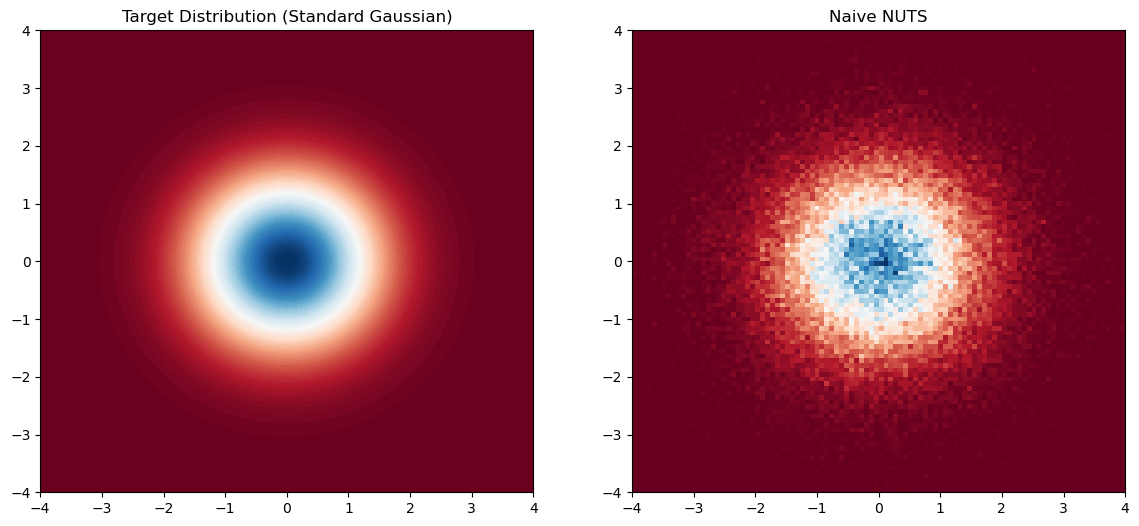

In [5]:
# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0  # if we do not consider burnin samples...
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

We will only change <code>build_tree</code> and <code>naive_NUTS</code> to achieve the efficient NUTS.

In [6]:
class efficientNUTS(naiveNUTS):
    """
    Efficient NUTS implementation as a class, from the parent class naiveNUTS.
    """
    
    def build_tree(self, theta, r, log_u, v, j, M=None, eps=0.1, delta_max=1000):
        """
        Recursively builds a binary tree of height-j for the naive NUTS algorithm,
        so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

        Args:
            theta (np.ndarray): Current position vector.
            r (np.ndarray): Current momentum vector, as a latent variable.
            log_u (float): Log slice variable, log-value for avoiding overflow.
            v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
            j (int): Current height/depth of the tree (start from 0).
            M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            eps (float): Stepsize for the leapfrog integration. Default is 0.1.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
        """
        if M is None:
            M = self.M
            
        # Base case: when we start our tree with height 0
        if j == 0:
            # Take one leapfrog step in the direction v
            theta_prime, r_prime = self.leapfrog(theta, r, v, M, eps)
            
            # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
            # whether or not we should accept this new position-momentum pair in C_prime
            _, _, hamiltonian_energy = self.state_energy(theta_prime, r_prime, M)
            if log_u <= -hamiltonian_energy:
                n_prime = 1  # number of accepted states in C_prime (corresponding to naive NUTS setting)
            else:
                n_prime = 0  # no accepted value, the tree would not be generated
            
            # Check if we should stop (energy condition), compute the stop indicator s
            s_prime = int(log_u - delta_max < -hamiltonian_energy)
            
            # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
            # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
            return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime

        else:
            # Recursion: build the left and right subtrees, following the doubling process
            # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
            theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime = self.build_tree(
                theta, r, log_u, v, j-1, M, eps, delta_max
            )
            
            if v == -1:
                theta_minus, r_minus, _, _, theta_double_prime, n_double_prime, s_double_prime = self.build_tree(
                    theta_minus, r_minus, log_u, v, j-1, M, eps, delta_max
                )
            else:
                _, _, theta_plus, r_plus, theta_double_prime, n_double_prime, s_double_prime = self.build_tree(
                    theta_plus, r_plus, log_u, v, j-1, M, eps, delta_max
                )

            # Metropolis step to choose between theta_prime and theta_double_prime
            # Generate a uniform random number for the Metropolis step
            if n_prime + n_double_prime > 0:  # avoid division by zero
                if np.random.uniform(0, 1) < n_double_prime / (n_prime + n_double_prime):
                    theta_prime = theta_double_prime  # update
            
            # Update the stop indicator s by combining s_prime and s_double_prime
            u_turn_indicator = int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            s_prime = s_prime * s_double_prime * u_turn_indicator
            
            # Update the total number of accepted states from both subtrees
            n_prime += n_double_prime
            
            return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime
    
    
    def NUTS_sample(self, theta0, num_samples, M=None, eps=0.1, delta_max=1000, monitor_results=True):
        """
        Run the naive NUTS sampler to generate samples.
        
        Args:
            theta0 (np.ndarray): Initial position vector.
            num_samples (int): Number of samples to generate.
            M (np.ndarray, optional): The mass matrix. If None, uses self.M or identity.
            eps (float): Stepsize for the leapfrog integration. Default is 0.1.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
            monitor_results (bool): Whether to print monitoring information. Default is True.

        Returns:
            Samples generated from the efficient NUTS.
        """
        if M is None:
            if self.M is None:
                # Default to identity matrix
                dim = theta0.shape[0]
                M = np.eye(dim)
            else:
                M = self.M
                
        dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
        theta = theta0  # initialise the current position with theta0
        samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
        num_samples_stayed = 0  # initialise the number of samples that stayed (does not move)
        
        for m in range(num_samples):
            # Resample momentum for every iteration
            r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
            # Resample the slice variable for every iteration
            _, _, H0 = self.state_energy(theta, r0, M)

            # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
            log_u = -H0 + np.log(np.random.uniform(low=0, high=1))
            
            # Initialise the binary tree at height j=0
            theta_minus, theta_plus = theta, theta
            r_minus, r_plus = r0, r0
            j = 0  # initialise the height of the tree
            n = 1  # initialise the number of accepted states (start from one single node)
            s = 1  # initialise the stop indicator s to 1 so the tree can start growing
            
            while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
                # Randomly choose the direction to build the tree
                v = np.random.choice([-1, 1])
                
                if v == -1:  # build the left subtree
                    theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime = self.build_tree(
                        theta_minus, r_minus, log_u, v, j, M, eps, delta_max
                    )
                else:  # build the right subtree
                    _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime = self.build_tree(
                        theta_plus, r_plus, log_u, v, j, M, eps, delta_max
                    )
                
                if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                    # Apply the efficient NUTS transition kernel directly here by updating theta
                    if np.random.uniform(0, 1) < n_prime / n:
                        theta = theta_prime  # update
                
                # Update the total number of accepted states
                n += n_prime

                # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
                s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
                j += 1  # increase the height of the tree
            
            # Append theta picked this iteration to samples
            samples[m, :] = theta
            
            # Check if sample stayed the same
            if m > 0 and np.allclose(theta, samples[m-1, :]):
                num_samples_stayed += 1
            
        if monitor_results:
            print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.')
            print(f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')
        
        return samples

There are total 2 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.


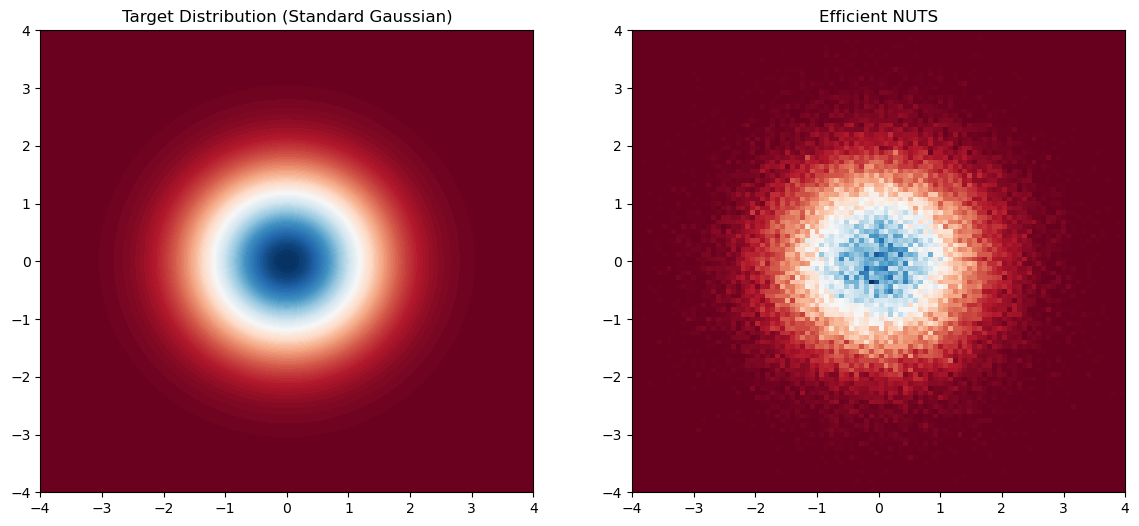

In [7]:
# Initialise the naive NUTS sampler
sampler = efficientNUTS(example_log_prob, example_grad_log_prob)
samples = sampler.NUTS_sample(theta0, num_samples, M=M)

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0  # if we do not consider burnin samples...
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Efficient NUTS')
plt.show()

The adaptive NUTS class can be constructed in the same way.

In [8]:
import torch

class adaptiveNUTS(naiveNUTS):
    """
    Adaptive NUTS implementation as a class, from the parent class naiveNUTS.
    """
    
    def find_reasonable_eps(self, theta, M=None, v=1):
        """
        Find a reasonable initial stepsize epsilon for HMC/NUTS.
        Args:
            theta (np.ndarray): Current position vector.
            M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            v (int, optional): Direction of the leapfrog step, either +1 (forward) or -1 (backward). Default is 1.
        """

        if M is None:
            M = self.M

        eps = 1.0  # initial guess
        d = theta.shape[0]  # dimension
        r = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))

        theta_prime, r_prime = self.leapfrog(theta, r, v, M, eps)
    
        _, _, H0 = self.state_energy(theta, r, M)
        _, _, H_prime = self.state_energy(theta_prime, r_prime, M)

        accept_prob = np.exp(H0 - H_prime)
        a = 1 if accept_prob > 0.5 else -1  # +1 if accept_prob > 0.5 else -1

        while (accept_prob ** a) > (2 ** (-a)):
            eps = eps * (2 ** a)
            theta_prime, r_prime = self.leapfrog(theta, r, v, M, eps)

            # Update the energy and accept_prob
            _, _, H_prime = self.state_energy(theta_prime, r_prime, M)
            accept_prob = np.exp(H0 - H_prime)
        return eps


    def build_tree(self, theta, r, theta0, r0, log_u, v, j, 
                   M=None, eps=0.1, delta_max=1000):
        """
        Recursively builds a binary tree of height-j for the naive NUTS algorithm,
        so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

        Args:
            theta (np.ndarray): Current position vector.
            r (np.ndarray): Current momentum vector, as a latent variable.
            theta0 (np.ndarray): Initial position vector at the start of the trajectory.
            r0 (np.ndarray): Initial momentum vector at the start of the trajectory.
            log_u (float): Log slice variable, log-value for avoiding overflow.
            v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
            j (int): Current height/depth of the tree (start from 0).
            M (np.ndarray, optional): The mass matrix. If None, uses self.M.
            eps (float): Stepsize for the leapfrog integration. Default is 0.1.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
        """
        if M is None:
            M = self.M
            
        # Base case: when we start our tree with height 0
        if j == 0:
            # Take one leapfrog step in the direction v
            theta_prime, r_prime = self.leapfrog(theta, r, v, M, eps)
            
            # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
            # whether or not we should accept this new position-momentum pair in C_prime
            _, _, hamiltonian_energy = self.state_energy(theta_prime, r_prime, M)
            if log_u <= -hamiltonian_energy:
                n_prime = 1  # number of accepted states in C_prime (corresponding to naive NUTS setting)
            else:
                n_prime = 0  # no accepted value, the tree would not be generated
            
            # Check if we should stop (energy condition), compute the stop indicator s
            s_prime = int(log_u - delta_max < -hamiltonian_energy)
            
            _, _, H0 = self.state_energy(theta0, r0, M)
            alpha = min(1, np.exp(H0 - hamiltonian_energy))  # single acceptance prob. for dual averaging

            # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
            # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
            # also we just have the single acceptance prob. alpha and count n_alpha=1 here
            return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime, alpha, 1

        else:
            # Recursion: build the left and right subtrees, following the doubling process
            # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
            theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = self.build_tree(
                theta, r, theta0, r0, log_u, v, j-1, M, eps, delta_max
            )
            
            if v == -1:
                theta_minus, r_minus, _, _, theta_double_prime, n_double_prime, s_double_prime, alpha_double_prime, n_alpha_double_prime = self.build_tree(
                    theta_minus, r_minus, theta0, r0, log_u, v, j-1, M, eps, delta_max
                )
            else:
                _, _, theta_plus, r_plus, theta_double_prime, n_double_prime, s_double_prime, alpha_double_prime, n_alpha_double_prime = self.build_tree(
                    theta_plus, r_plus, theta0, r0, log_u, v, j-1, M, eps, delta_max
                )

            # Metropolis step to choose between theta_prime and theta_double_prime
            # Generate a uniform random number for the Metropolis step
            if n_prime + n_double_prime > 0:  # avoid division by zero
                if np.random.uniform(0, 1) < n_double_prime / (n_prime + n_double_prime):
                    theta_prime = theta_double_prime  # update
            
            # Update the stop indicator s by combining s_prime and s_double_prime
            u_turn_indicator = int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            s_prime = s_prime * s_double_prime * u_turn_indicator
            
            # Update the total number of accepted states from both subtrees
            n_prime += n_double_prime

            # Update the total acceptance probability (summation) and count of final doubling iteration n_alpha_prime
            alpha_prime += alpha_double_prime
            n_alpha_prime += n_alpha_double_prime
            
            return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime
    
    
    def NUTS_sample(self, theta0, num_samples, num_samples_adapt, target_accept_rate, 
                    M=None, delta_max=1000, monitor_results=True):
        """
        Run the naive NUTS sampler to generate samples.
        
        Args:
            theta0 (np.ndarray): Initial position vector.
            num_samples (int): Number of samples to generate.
            num_samples_adapt (int): Number of samples for the adaptation process of stepsize.
            target_accept_rate (float): Target acceptance rate for dual averaging, denoted as delta in Hoffman's paper.
            M (np.ndarray, optional): The mass matrix. If None, uses self.M or identity.
            delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
            monitor_results (bool): Whether to print monitoring information. Default is True.

        Returns:
            samples: Samples generated from the efficient NUTS.
            eps_list: List of change of stepsizes before the adaption process ends.
            H_NUTS_history: Sequence of H_NUTS along with running samples, defined by dual averaging.
            n_alpha_history: Number of newly added samples by last build_tree process, along with all generated samples.
                             i.e. each generated sample from the adaptive NUTS would have a singel n_alpha, and we 
                             compose them into the final n_alpha_history.
            h_NUTS_history: The cumulative mean of H_NUTS_history, expected to see the convergence to the target_accept_rate by
                            the dual averaging within the adaption phase.
        """

        if M is None:
            if self.M is None:
                # Default to identity matrix
                dim = theta0.shape[0]
                M = np.eye(dim)
            else:
                M = self.M
        

        # Initialise an appropriate stepsize epsilon using the heuristic, from the initial position theta0
        eps0 = self.find_reasonable_eps(theta=theta0, M=M, v=1)

        mu = np.log(10 * eps0)  # target log stepsize
        eps0_bar = 1.0  # initial smoothed stepsize
        h_bar = 0.0  # initial average acceptance probability
        gamma = 0.05  # controls the speed of adaptation
        t0 = 10.0  # stabilisation parameter
        kappa = 0.75  # controls the shrinkage of step size

        dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
        theta = theta0  # initialise the current position with theta0
        eps, log_eps = eps0, np.log(eps0)  # initialise stepsize and its log-form
        eps_bar, log_eps_bar = eps0_bar, np.log(eps0_bar)  # initialise smoothed stepsize and its log-form

        samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
        num_samples_stayed = 0  # initialise the number of samples that stayed (does not move)
        eps_list = []  # to store the stepsize values until adaption ends
        H_NUTS_history = []  # to store the H_NUTS for each sample/iteration, initialised as a list
        n_alpha_history = []  # to store the number of all states explored during the final doubling for each iteration, considered as the list of |B_t^final|
        h_NUTS_history = []  # to store the cumulative mean of {H_t_NUTS} from iteration 1 to iteration m, initialised as a list (this list should converge to target accpet prob.)
        
        running_sum, running_count = 0, 0

        for m in range(num_samples):
            # Iteration index for dual averaging (1-based)
            t = m + 1

            # Resample momentum for every iteration
            r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
            # Resample the slice variable for every iteration
            _, _, H0 = self.state_energy(theta, r0, M)

            # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
            log_u = -H0 + np.log(np.random.uniform(low=0, high=1))
            
            # Initialise the binary tree at height j=0
            theta_minus, theta_plus = theta, theta
            r_minus, r_plus = r0, r0
            j = 0  # initialise the height of the tree
            n = 1  # initialise the number of accepted states (start from one single node)
            s = 1  # initialise the stop indicator s to 1 so the tree can start growing
            
            while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
                # Randomly choose the direction to build the tree
                v = np.random.choice([-1, 1])
                
                if v == -1:  # build the left subtree
                    theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime, alpha, n_alpha = self.build_tree(
                        theta_minus, r_minus, theta, r0, log_u, v, j, M, eps, delta_max
                    )
                else:  # build the right subtree
                    _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha, n_alpha = self.build_tree(
                        theta_plus, r_plus, theta, r0, log_u, v, j, M, eps, delta_max
                    )
                
                if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                    # Apply the efficient NUTS transition kernel directly here by updating theta
                    if np.random.uniform(0, 1) < n_prime / n:
                        theta = theta_prime  # update
                
                # Update the total number of accepted states
                n += n_prime

                # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
                s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
                j += 1  # increase the height of the tree
            
            # Append theta picked this iteration to samples
            samples[m, :] = theta
            
            # Check if sample stayed the same
            if m > 0 and np.allclose(theta, samples[m-1, :]):
                num_samples_stayed += 1
            
            # Monitor H_t_NUTS as the average accepted prob. from final doubling band (alpha, n_alpha returned by last build_tree_adapt)
            if n_alpha > 0:
                H_t_NUTS = alpha / n_alpha
            else:
                H_t_NUTS = np.nan

            H_NUTS_history.append(H_t_NUTS)
            n_alpha_history.append(n_alpha)

            # Monitor the convergence under dual average - the convergence should be EXPECTATION OF H_t^NUTS, but not the sequence of H_t^NUTS itself!
            # Record the expectation of H_NUTS_history for every iteration to result a sequence of expectation of H_t^NUTS, which is {h_t^NUTS}, 
            # where h_t^NUTS = sample mean of {H_t^NUTS} up to t
            running_sum += H_t_NUTS
            running_count += 1
            h_t_NUTS = running_sum / running_count
            h_NUTS_history.append(h_t_NUTS)

            # Dual averaging to adapt stepsize (eps)
            if m < num_samples_adapt:  # adaption process
                # Dual averaging
                # Step 1: update h_bar, which is derived from H_t = target_accept_rate - H_NUTS
                h_bar = (1 - 1 / (t + t0)) * h_bar + (1 / (t + t0)) * (target_accept_rate - alpha / n_alpha)

                # Step 2: update eps and eps_bar by substiting x = log_eps into the formula of dual averaging
                log_eps = mu - (np.sqrt(t) / gamma) * h_bar
                log_eps_bar = t**-kappa * log_eps + (1 - t**-kappa) * log_eps_bar

                # Step 3: Update eps and eps_bar 
                # Before that, WE NEED TO ENSURE BOTH log_eps AND log_eps_bar ARE IN NUMPY FLOAT!
                # This is necessary: if we define our Bayesian model with parameters in tensor form, these two would be in tensor as well!
                # Then it will induce TypeError - which takes me 2h to fix this bug...
                if torch.is_tensor(log_eps):
                    log_eps = log_eps.detach().cpu().numpy().astype(np.float64)
                if torch.is_tensor(log_eps_bar):
                    log_eps_bar = log_eps_bar.detach().cpu().numpy().astype(np.float64)
                eps = np.exp(log_eps)
                eps_bar = np.exp(log_eps_bar)
                eps_list.append(eps)  # append the adapted stepsize at this iteration
            else:
                eps = eps_bar  # fix the stepsize after adaptation period

        if monitor_results:
            print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.')
            print(f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')
        
        return samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history

There are total 24892 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.751.


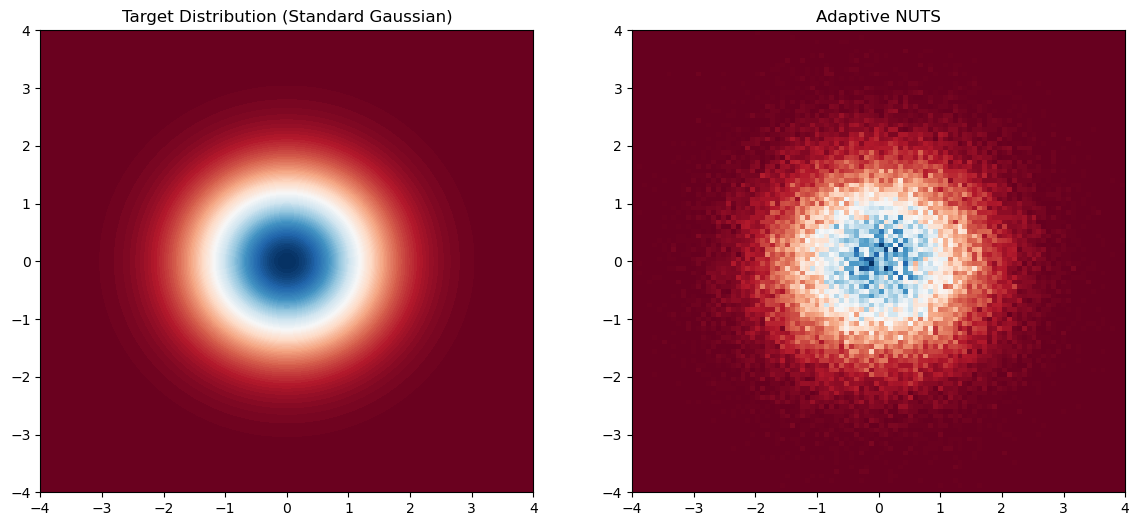

In [9]:
num_samples_adapt = 50000
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# Initialise the naive NUTS sampler
sampler = adaptiveNUTS(example_log_prob, example_grad_log_prob)
samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = sampler.NUTS_sample(
    theta0, num_samples, num_samples_adapt, target_accept_rate, M=M)

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0  # if we do not consider burnin samples...
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Adaptive NUTS')
plt.show()

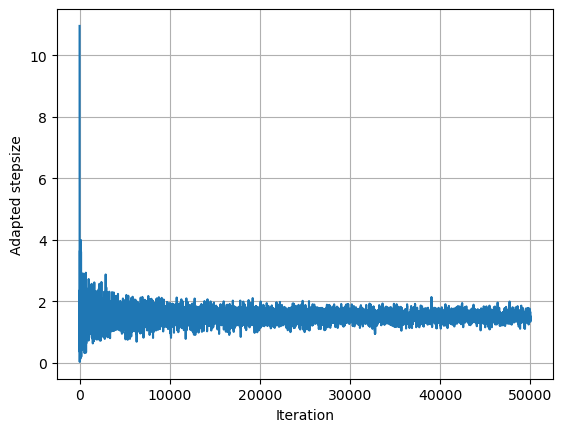

In [10]:
plt.plot(eps_list)
plt.xlabel('Iteration')
plt.ylabel('Adapted stepsize')
plt.grid()
plt.show()

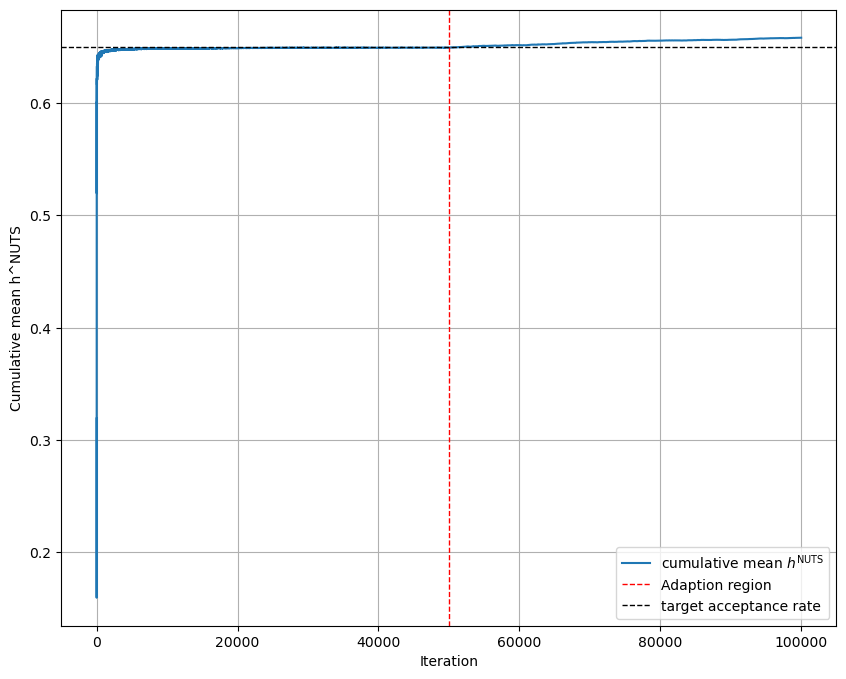

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(h_NUTS_history, label='cumulative mean $h^{\\mathrm{NUTS}}$')
plt.axvline(x=num_samples_adapt, color='r', linestyle='--', linewidth=1, label='Adaption region')
plt.axhline(y=target_accept_rate, color='k', linestyle='--', linewidth=1, label='target acceptance rate')
plt.xlabel('Iteration')
plt.ylabel('Cumulative mean h^NUTS')
plt.legend()
plt.grid()
plt.show()

# Section 2: Bayesian inference example analysis

We now carry a real data analysis on our NUTS. The dataset chosen is from MATH70073 Coursework which is related to the national police shootings in the US from 2015 to 2024. Source: https://github.com/washingtonpost/data-police-shootings, with version 2 (v2).

For race, it uses abbreviations that

- W: White

- B: Black

- A: Asian heritage

- N: Native American

- H: Hispanic

- O: Other

- --: Unknown

In [ ]:
import pandas as pd

file_path = 'c:/Users/Peiyi/Desktop/NUTS simulation/data/fatal-police-shootings-data.csv'

df = pd.read_csv(file_path)  # we remove the index column (which is the first column by pandas default)
# We further remove unnecessary columns/features that are not interested in our analysis
columns_to_drop = ['id', 'city', 'county', 'latitude', 'longitude', 
                   'location_precision', 'name', 'race_source', 'agency_ids']
df = df.drop(columns=columns_to_drop)

# Replace date by corresponding year only
df['date'] = pd.to_datetime(df['date']).dt.year

df.head()

Again we consider the police shootings over 51 US states in the period 2015-2024, under the assumption that **the state population remain approximately constant over years**. 

We may first consider the raw count of number of police shootings in each state during 2015-2024 and report them in a bar chart.

In [ ]:
# # number of police shootings in each state during 2015-2024, in descending order
state_counts = df['state'].value_counts()

plt.figure(figsize=(14, 6))
ax = state_counts.plot(kind='bar')
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of police shootings (2015-2024)', fontsize=12)
plt.title('Police shootings by state (2015-2024)', fontsize=16)

# annotate counts above bars
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(int(y), (x, y), ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

In [ ]:
from itertools import product

# A brief check on the (state, date) keys in the dataset
# Check the number of unique states (51) and unique years (10)
print('Unique states:', df['state'].nunique())
print('Unique years:',  df['date'].nunique())

# Check whether we have NaN state and year
print("NaN in state:", df['state'].isna().sum())
print("NaN in date: ", df['date'].isna().sum())

# See which (state, date) combos are present vs all possible combos
states = sorted(df['state'].dropna().unique())  # sort in alphabetical order
dates  = sorted(df['date'].dropna().unique())  # sort in ascending order
present = set(df.groupby(['state','date']).size().index)  # set of (state, date) combos present in the data
all_combos = set(product(states, dates))  # set of all possible (state, date) combos, which should be of length 51*10=510
missing = sorted(list(all_combos - present))  # list of missing (state, date) combos, in sorted order
print('Number of expected combos:', len(states)*len(dates))
print('Number missing:', len(missing))
print('Example missing combos:', missing)

The raw count of number of police shootings is not a fair statistic to compare and rank US states, this is because larger states like California and Texas are more populated than states like Rhode Island, and such huge population base leads to higher counts. To accurately describe the police shootings by US state, we should use incidence rates instead, which are computed as:
$$
\frac{\text{total number of shootings over a period}}{\text{total population over a period}} \times \text{population size interested}
$$

The incidence rate computed here would be the incidence rate for each state per 1 million people.

We now use necessary information in <code>df</code> to compute the incidence rate for each state and merge them into a new dataframe <code>df_new</code> for our later analysis. This is constructed in 3 steps:

1. First construct <code>df_new</code> with columns: 'state', 'date' and 'shooting count'. This should have length 510, for total 51 states and 10 years. The shooting count would record the number of police shootings per state per year.

2. Add a new column named as 'state population' that records the population over each state for corresponding year. The yearly state population information can be found in https://wonder.cdc.gov/wonder/help/single-race.html, but missing 2024 data. Here we apply Excel quick analysis/trendline for fitting the data of 2024 by using 2015-2023 populations (based on OLS principle), up to the nearest integer.

3. Add a new column for the incidence police shooting rate per year per 100k people.

In [ ]:
# Step 1:
# Merge the data to get counts of shootings per (state, date)
# but we should assign 0 counts to the missing (state, date) combos
cumbo_counts = df.groupby(['state', 'date']).size().reset_index(name='shooting count')
all_combos_df = pd.DataFrame(list(all_combos), columns=['state', 'date'])
df_new = pd.merge(all_combos_df, cumbo_counts, on=['state', 'date'], how='left').fillna(0)
df_new['shooting count'] = df_new['shooting count'].astype(int)  # convert count to integer type

# Sort df_new by state and date
df_new = df_new.sort_values(['state', 'date'], ignore_index=True)

# Step 2:
file_path = 'C:/Users/Peiyi/Desktop/NUTS simulation/data/Single-Race Population Estimates by State/merged 2015-2024.xlsx'

state_pop_df = pd.read_excel(file_path)
columns_to_drop = ['States', 'States Code']
state_pop_df = state_pop_df.drop(columns=columns_to_drop)

# Merge state_pop_df with df_new by state
df_new = pd.merge(df_new, state_pop_df, left_on='state', right_on='state', how='left')

# Step 3:
# Vectorised approach 
years = df_new['date'].astype(str)
df_new['incidence rate per 1e5 people'] = (
    df_new['shooting count'] / 
    df_new[[f'{year} Population' for year in df_new['date']]].values[range(len(df_new)), range(len(df_new))]
) * 100000

df_new.head()

In [ ]:
# Calculate average incidence rate per state
state_avg_incidence = df_new.groupby('state')['incidence rate per 1e5 people'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
ax = state_avg_incidence.plot(kind='bar')

# Customize the chart
plt.xlabel('State', fontsize=12)
plt.ylabel('Average incidence rate', fontsize=12)
plt.title('Average incidence rate of police shootings per state (per 100,000 population, 2015-2024)', fontsize=16)

# annotate counts above bars
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(round(y, 3), (x, y), ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

We specify the Bayesian Poisson random effects model to estimate incidence rates (per 100,000 people) of police shootings for each US state, from count data stratified by state and year.
$$
\begin{aligned}
Y_{t,s} &\sim \mathrm{Poi}(\lambda_{t, s})\\
\log \lambda_{t, s} &= \log (P_{t, s}/10^5) + \log \theta_{t, s}\\
\log \theta_{t, s} &= \alpha + \beta_s + \gamma_t\\
\alpha &\sim \mathcal{N}(0, 10^2)\\
\beta_s &\sim \mathcal{N}(0, \sigma_\beta^2)\\
\gamma_t &\sim \mathcal{N}(0, \sigma_\gamma^2)\\
\sigma_\beta &\sim \text{Half-Cauchy}(0,1)\\
\sigma_\gamma &\sim \text{Half-Cauchy}(0,1)
\end{aligned}
$$

where:

1. $Y_{t,s}$: observation (number of police shootings) at year $t$ for state $s$, where we have 10 years (2015-2024, so $t=1,\cdots, 10$) and 50 states and the D.C. as features (so $s=1,\cdots,51$), so in total we would have 510 observations.

2. $\lambda_{t, s}$: expected police shootings counts at year $t$ for state $s$, which is done as a product between the incidence rate (per 100,000 people) of state $s$ at year $t$ (denoted as $\theta_{t, s}$) and the state population $P_{t, s}$ of state $s$ at year $t$, divided by $10^5$ corresponding to the population size interested for computing the incidence rate (the resulting $\log (P_{t, s}/10^5)$ can be seen as an offset term).

3. $\alpha$: baseline log-incidence rate parameter (fixed effect). We assume it is in a normal distribution symmetric at 0 with variance 100 as a very weakly informative and broad prior.

4. $\beta_s$: state-specific random effect (subscript $s$ means for state $s$). We total have 51 different $\beta_s$ specific to each state, and $\beta_s$ are assumed to be independent with each other for different states $s$.

5. $\sigma_\beta$: variance parameter across states, we need this to be positive.

6. $\gamma_t$: time-specific random effect (subscript $t$ means for year $t$). We total have 10 different $\gamma_t$ specific to each year, and $\gamma_t$ are assumed to be independent with each other for different time $t$.

7. $\sigma_\gamma$: variance parameter across time, we need this to be positive.

In order to improve the efficiency and avoid funnel geometry, we apply the non-centered parameterisation, that is, we write:

- $\beta_s \sim \mathcal{N}(0, \sigma_\beta^2) \iff \beta_s = \sigma_\beta z_\beta$, with $z_\beta \sim \mathcal{N}(0,1)$ being as some standard Gaussian random effects.

- $\gamma_t \sim \mathcal{N}(0, \sigma_\gamma^2) \iff \gamma_t = \sigma_\gamma z_\gamma$, with $z_\gamma \sim \mathcal{N}(0,1)$ being as some standard Gaussian random effects.

Also, if $X \sim \text{Half-Cauchy}(0,1)$, its density function is simply
$$
f(x) = \frac{2}{\pi}\frac{1}{1 + x^2} = 2 \times \text{Cauchy}(x; 0, 1)
$$
as the Half-Cauchy distribution is the absolute value of a Cauchy distribution, together with symmetry.

In order to avoid overflow, we may set our position vector as
$$
\theta = (\alpha, \log \sigma_\beta, \log \sigma_\gamma, z_\beta, z_\gamma), \quad z_\beta \in \mathbb{R}^{51}, z_\gamma \in \mathbb{R}^{10}
$$
and this is represented as the input argument <code>params</code> in the later code.

In [ ]:
from torch.distributions import Normal, Cauchy

class PoissonRandomEffectsModel:
    def __init__(self, Y, P, state_indices, year_indices, n_states=51, n_years=10, device='cpu'):
        """
        Initialise the model with data.
        
        Args:
            Y (np.ndarray): Array of observed counts, of shape (n_obs, ), where n_obs = n_states * n_years.
            P (np.ndarray): Array of populations, of shape (n_obs, ).
            state_indices (np.ndarray): Array of state indices (0 to n_states-1).
            year_indices (np.ndarray): Array of year indices (0 to n_years-1).
            n_states: Number of states. Default is 51 for 51 states in the US.
            n_years: Number of years. Default is 10 for years 2015-2024.
            device: the device used. Default is cpu.
        """
        
        # Store as torch tensors (single precision), shooting counts, population and indices must be in integer form
        self.device = device
        self.Y = torch.as_tensor(Y, dtype=torch.int64, device=self.device)
        self.P = torch.as_tensor(P, dtype=torch.int64, device=self.device)
        self.state_indices = torch.as_tensor(state_indices, dtype=torch.int64, device=self.device)
        self.year_indices = torch.as_tensor(year_indices, dtype=torch.int64, device=self.device)
        self.n_states = n_states
        self.n_years = n_years
        self.n_obs = self.Y.numel()  # total number of observations, .numel() is tensor-specific

        # Parameter dimensions
        self.dim_alpha = 1
        self.dim_sigma_beta = 1
        self.dim_sigma_gamma = 1
        self.dim_z_beta = n_states
        self.dim_z_gamma = n_years
        
        self.total_dim = self.dim_alpha + self.dim_sigma_beta + self.dim_sigma_gamma + self.dim_z_beta + self.dim_z_gamma

    def unpack_parameters(self, params):
        """
        Unpack the parameter vector/position into individual components.
        
        Args:
            params (np.ndarray): Parameter vector of shape (total_dim, ), containing (alpha, log_sigma_beta, 
            log_sigma_gamma, z_beta, z_gamma, beta, gamma).
        Returns:
            The parameters (alpha, sigma_beta, sigma_gamma, beta_s, gamma_t) in tensor form.
        """

        params = torch.as_tensor(params, dtype=torch.float64, device=self.device)  # convert our params into tensors
        idx = 0  # initialise the index

        # Fixed effects
        alpha = params[idx]
        idx += 1

        # Standard deviations (positive parameters - we will use log transform)
        log_sigma_beta = params[idx]
        sigma_beta = torch.exp(log_sigma_beta)
        idx += 1

        log_sigma_gamma = params[idx]
        sigma_gamma = torch.exp(log_sigma_gamma)
        idx += 1

        # Random effects (non-centered parameterisation)
        z_beta = params[idx : idx + self.n_states]
        idx += self.n_states
        z_gamma = params[idx : idx + self.n_years]
        idx += self.n_years

        return alpha, sigma_beta, sigma_gamma, z_beta, z_gamma

    def log_joint_density(self, params):
        """
        Compute the log joint (unnormalised posterior) using torch ops.
        Args:
            params: numpy array or torch tensor. If numpy, convert to torch internally.
        Returns: 
            The value of log joint density (unnormalised log posterior) with input parameters, in terms of tensor on device.
        """
        # Convert input to torch tensor if needed
        if not isinstance(params, torch.Tensor):
            params = torch.as_tensor(params, dtype=torch.float64, device=self.device)
        else:
            params = params.to(dtype=torch.float64, device=self.device)

        # Unpack parameters in terms of torch tensors
        alpha, sigma_beta, sigma_gamma, z_beta, z_gamma = self.unpack_parameters(params)

        # Apply sum-to-zero constraints to ensure identifiability and interpretability
        beta = sigma_beta * (z_beta - torch.mean(z_beta))
        gamma = sigma_gamma * (z_gamma - torch.mean(z_gamma))

        # Log likelihood (Poission, unnormalised form)
        log_offset = torch.log(self.P / 1e5)
        log_lambda = log_offset + alpha + beta[self.state_indices] + gamma[self.year_indices]
        log_likelihood = torch.sum(self.Y * log_lambda - torch.exp(log_lambda))  # discarding the factorial in the denominator

        # Priors
        # alpha ~ N(0, 10^2)
        prior_alpha = Normal(0, 10)
        log_prior_alpha = prior_alpha.log_prob(alpha)

        # z_beta, z_gamma ~ N(0,1) - standard normal for non-centered parameterisation
        prior_standard_normal = Normal(0, 1)
        # Summation for every component, 
        # this is because independence: joint prior = product -> log joint prior = sum
        log_prior_z_beta = prior_standard_normal.log_prob(z_beta).sum()
        log_prior_z_gamma = prior_standard_normal.log_prob(z_gamma).sum()

        # sigma_beta, sigma_gamma ~ Half-Cauchy(0,1)
        # log p(sigma) = log(2/pi) - log(1 + sigma^2)
        prior_standard_cauchy = Cauchy(0, 1)
        log_prior_sigma_beta = prior_standard_cauchy.log_prob(sigma_beta) + torch.log(torch.tensor(2, dtype=torch.float64, device=self.device))
        log_prior_sigma_gamma = prior_standard_cauchy.log_prob(sigma_gamma) + torch.log(torch.tensor(2, dtype=torch.float64, device=self.device))

        # Unnormalised posterior = prior * likelihood -> log unnormalised posterior = log prior + log likelhood
        # We can take unnormalised form for all of them and it does not affect the result
        log_prior = log_prior_alpha + log_prior_z_beta + log_prior_z_gamma + log_prior_sigma_beta + log_prior_sigma_gamma
        log_posterior = log_likelihood + log_prior  # unnormalised log posterior in scalar torch tensor form

        return log_posterior


    def grad_log_joint_density(self, params):
        """
        Compute gradient of log_joint_density w.r.t. params.
        """

        # Convert to torch tensor on correct device and make requires_grad, different from params for differentiation
        if not isinstance(params, torch.Tensor):
            params_diff = torch.tensor(params, dtype=torch.float64, device=self.device).clone().detach().requires_grad_(True)
        else:
            params_diff = params.to(dtype=torch.float64, device=self.device).clone().detach().requires_grad_(True)

        # Compute the unnormalised log posterior
        log_posterior = self.log_joint_density(params_diff)

        # Force zero gradients at the beginning (if it already has a preset gradient)
        if params_diff.grad is not None:
            params_diff.grad.zero_()

        # Backward to compute grads
        log_posterior.backward()

        # Extract gradient to numpy on CPU
        grad_log_posterior = params_diff.grad.detach().cpu().numpy().astype(np.float64)

        return grad_log_posterior

In [ ]:
# Prepare the data needed for construct our Poisson random effect model

# Create state and year indices
states = sorted(df_new['state'].unique())
years = sorted(df_new['date'].unique())

# Use dictionary to store state/year and their corresponding indices    
state_to_idx = {state: i for i, state in enumerate(states)}
year_to_idx = {year: i for i, year in enumerate(years)}
    
n_states = len(states)
n_years = len(years)
    
# Extract data
Y = df_new['shooting count'].values  # (510, )
state_indices = np.array([state_to_idx[state] for state in df_new['state']])
year_indices = np.array([year_to_idx[year] for year in df_new['date']])
    
# Get population for each state-year combination
P = np.zeros(len(df_new))  # initialise
for i, row in df_new.iterrows():
    year = row['date']
    pop_col = f'{year} Population'
    P[i] = row[pop_col]

### Naive NUTS implementation on this example

Unlike the previous toy examples, here we must qualitatively find an appropriate stepsize $\epsilon$ (and that can be different from the default 0.1). If the stepsize is too big, the leapfrog jump would be big and we barely cannot accept a sample - the tree would stop generate due to large jumps meeting the stopping criteria too early. Meanwhile, a too small stepsize would cause very small jumps to lead very inefficient sampling. We may try some stepsize value and see their jumps.

In [ ]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)
sampler = naiveNUTS(model.log_joint_density, model.grad_log_joint_density)

# Initial position-momentum pair
theta0 = np.zeros(model.total_dim)
r0 = np.random.multivariate_normal(mean=np.zeros(model.total_dim), cov=np.eye(model.total_dim))

for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:
    theta1, r1 = sampler.leapfrog(theta0.copy(), r0.copy(), v=1, M=np.eye(model.total_dim), eps=eps)
    print(f'The magitude of jump with stepsize {eps}:', np.linalg.norm(theta1 - theta0))

Though the position vector is of a very high dimension to cause a huge difference in maginitude, we may still wish to pick $\epsilon=0.01$.

In [ ]:
num_samples = 100

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)
    
# Run NUTS - choice of stepsize here would be really important!!!
samples, C, avg_accept_prob = sampler.NUTS_sample(
    theta0, num_samples, M, eps=0.01, monitor_results=False
)

# Samples are params following the form as unpack_parameters: (alpha, log_sigma_beta, log_sigma_gamma, z_beta, z_gamma)

For the same model but with a different starting point.

In [ ]:
# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))
r0 = np.random.multivariate_normal(mean=np.zeros(model.total_dim), cov=np.eye(model.total_dim))

for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:
    theta1, r1 = sampler.leapfrog(theta0.copy(), r0.copy(), v=1, M=np.eye(model.total_dim), eps=eps)
    print(f'The magitude of jump with stepsize {eps}:', np.linalg.norm(theta1 - theta0))

In [ ]:
# Run NUTS - choice of stepsize here would be really important!!!
# Here we choose the stepsize be 0.005
samples1, C1, avg_accept_prob1 = sampler.NUTS_sample(
    theta0, num_samples, M, eps=0.005, monitor_results=False
)

In [ ]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

### Efficient NUTS implementation on this example

In [ ]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)
sampler = efficientNUTS(model.log_joint_density, model.grad_log_joint_density)
num_samples = 100

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)
    
# Run NUTS - choice of stepsize here would be really important!!!
samples = sampler.NUTS_sample(
    theta0, num_samples, M, eps=0.01, monitor_results=False
)

# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))

# Run NUTS - choice of stepsize here would be really important!!!
samples1 = sampler.NUTS_sample(
    theta0, num_samples, M, eps=0.005, monitor_results=False
)

In [ ]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

### Adaptive NUTS implementation on this example

In [ ]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)
sampler = adaptiveNUTS(model.log_joint_density, model.grad_log_joint_density)

# Both num_samples and num_samples_adapt would affect the speed of sampling
# more num_samples_adapt would possibly reduce the stepsize to slow down the convergence and increase the cost...
# Pretty slow: more than 2h on local laptop... (I don't have the result tbh...)
num_samples = 100
num_samples_adapt = 20
target_accept_rate = 0.65

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)

# Run adaptive NUTS
samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = sampler.NUTS_sample(
    theta0, num_samples, num_samples_adapt, target_accept_rate, M, monitor_results=False
)

# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))

# Run adaptive NUTS
samples1, eps_list1, H_NUTS_history1, n_alpha_history1, h_NUTS_history1 = sampler.NUTS_sample(
    theta0, num_samples, num_samples_adapt, target_accept_rate, M, monitor_results=False
)

In [ ]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(eps_list)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(h_NUTS_history, label='cumulative mean $h^{\\mathrm{NUTS}}$')
plt.axvline(x=num_samples_adapt, color='r', linestyle='--', linewidth=1, label='Adaption region')
plt.axhline(y=target_accept_rate, color='k', linestyle='--', linewidth=1, label='target acceptance rate')
plt.xlabel('Iteration')
plt.ylabel('Cumulative mean h^NUTS')
plt.legend()
plt.grid()
plt.show()

# Section 3: Investigation on single/small amount of build tree processes

Since all NUTS algorithms are based on the naive NUTS - the difference between is mainly the efficiency, but the sampling essence is the same. Therefore, in this section we just apply the naive NUTS for our analysis.

In [84]:
def extract_positions(C):
    """
    Extract all possible position samples generated from the (naive) NUTS. 
    The selected position sample is chosen uniformly from all possible position samples.
    
    Arg:
        C (list): the total set of possible accepted (position, momentum) from the naive NUTS based on the previous sample.
    Return:
        pos_chain (np.ndarray): all possible states for the position chain from C (discarding the momentum chain).
    """

    pos_chain = np.vstack([pos for pos, mmt in C])

    return pos_chain

In [85]:
def collecting_positions(theta0, num_samples, log_joint_density, grad_log_joint_density, 
                         M=np.eye(theta0.shape[0]), eps=0.1, delta_max=1000):
    """
    Run naive NUTS for num_samples iterations and collect the position trajectories (the position chains produced during each build_tree step).

    Args:
        theta0 (np.ndarray): initial position vector.
        num_samples (int): Number of NUTS iterations to run (i.e. how many position chains to collect).
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
        eps (float): Stepsize for the leapfrog integration. Default is 0.1.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
    Return:
        all_positions (list): List of length (num_samples, ). Each element is a 2-D numpy array with shape (T_i, D), 
                              containing the sequence of positions visited during that iteration's tree construction. 
                              Note that T_i depend on the stopping criteria (U-turn, energy) and may vary between iterations.
    """

    # Initialise the all_positions, as a list, storing the position chain from each iteration
    # the so-called 'position chain' refers the position samples in C for each iteration of naive NUTS
    # if we run n iterations (so total n position samples for naiveNUTS), 
    # then the i-th position sample is chosen uniformly from the i-th element in all_positions,
    # where the i-th element of all_positions contain all possible position coordinates during the i-th build tree process.
    all_positions = []

    theta = theta0  # initialise the starting position with preset value

    # Define the naive NUTS sampler
    sampler = naiveNUTS(log_joint_density, grad_log_joint_density)

    for _ in range(num_samples):
        # Generate one next (position, momentum) sample with the previous position theta 
        sample, C, _ = sampler.NUTS_sample(theta, 1, M, eps, delta_max, monitor_results=False)
    
        # Extract the position chain as all generated position samples for one iteration
        pos_chain = extract_positions(C)
        all_positions.append(pos_chain)
        theta = sample.reshape(-1)  # reshape

    return all_positions

**Case 1: banana density (very sharp), with different starting points**

In [86]:
def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 30 - y**2 / 30 - 10 * (y - x**2)**2

In [95]:
def plot_trajectory(log_joint_density_component_form, all_positions,
                    x_low, x_high, y_low, y_high):
    """Plot the trajectory for all positions in the position chain.
    Args:
        log_joint_density_component_form (Callable): log joint density in (2D) component form.
        all_positions (List): List of length (num_samples, ). Each element is a 2-D numpy array with shape (T_i, D), 
                              containing the sequence of positions visited during that iteration's tree construction. 
                              Note that T_i depend on the stopping criteria (U-turn, energy) and may vary between iterations.
        x_low, x_high (floats): range for the plot in x-direction.
        y_low, y_high (floats): range for the plot in y-direction.
    """
    
    plt.figure(figsize=(12, 12))

    # Draw contour background
    x_bb = np.linspace(x_low, x_high, 100)
    y_bb = np.linspace(y_low, y_high, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_joint_density_component_form(X_bb, Y_bb))
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='Greys')
    #contour = plt.contour(X_bb, Y_bb, Z_bb, levels=10, colors='gray', alpha=0.5, linewidths=0.5)
    #plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2f')

    # Plot trajectories on top
    cmap = plt.get_cmap('tab10')  # different colors for at most 10 chains (so num_samples <= 10)
    for i, pos_chain in enumerate(all_positions):
        color = cmap(i % 10)
        plt.plot(pos_chain[:, 0], pos_chain[:, 1], linestyle='-', linewidth=1, alpha=0.8, color=color, zorder=1, 
                 label=f'Chain {i+1}')
        plt.scatter(pos_chain[:, 0], pos_chain[:, 1], s=20, alpha=0.95, color=color, zorder=1)

        # Highlight first sample, as the taken position sample for the naiveNUTS
        plt.scatter(pos_chain[0, 0], pos_chain[0, 1], s=100, marker='X', edgecolor='k',
                    linewidth=0.7, zorder=2, color=color)

    plt.title(f'Target Distribution, start from {all_positions[0][0]}', fontsize=16)
    plt.legend(fontsize=10)
    plt.show()

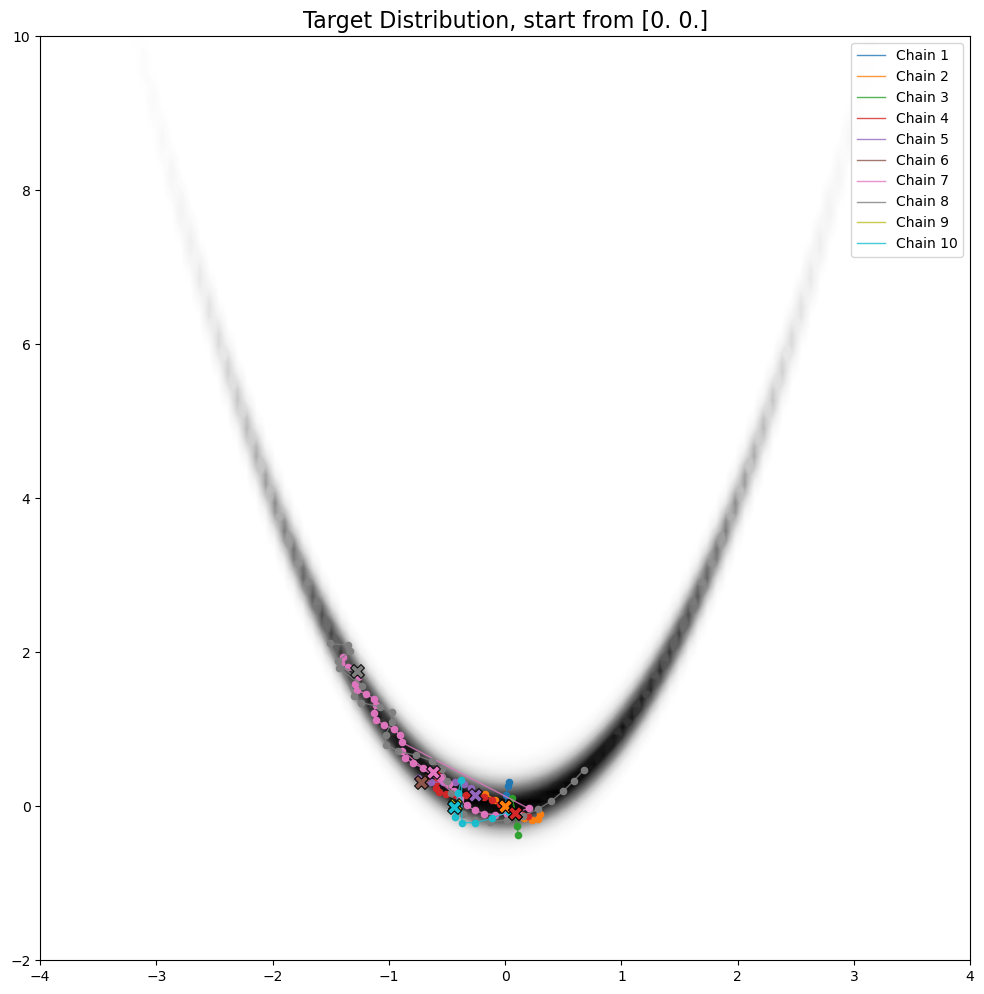

In [96]:
theta0 = np.array([0, 0])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

# Plot range for banana density
x_low, x_high = -4, 4
y_low, y_high = -2, 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_banana, all_positions, x_low, x_high, y_low, y_high)

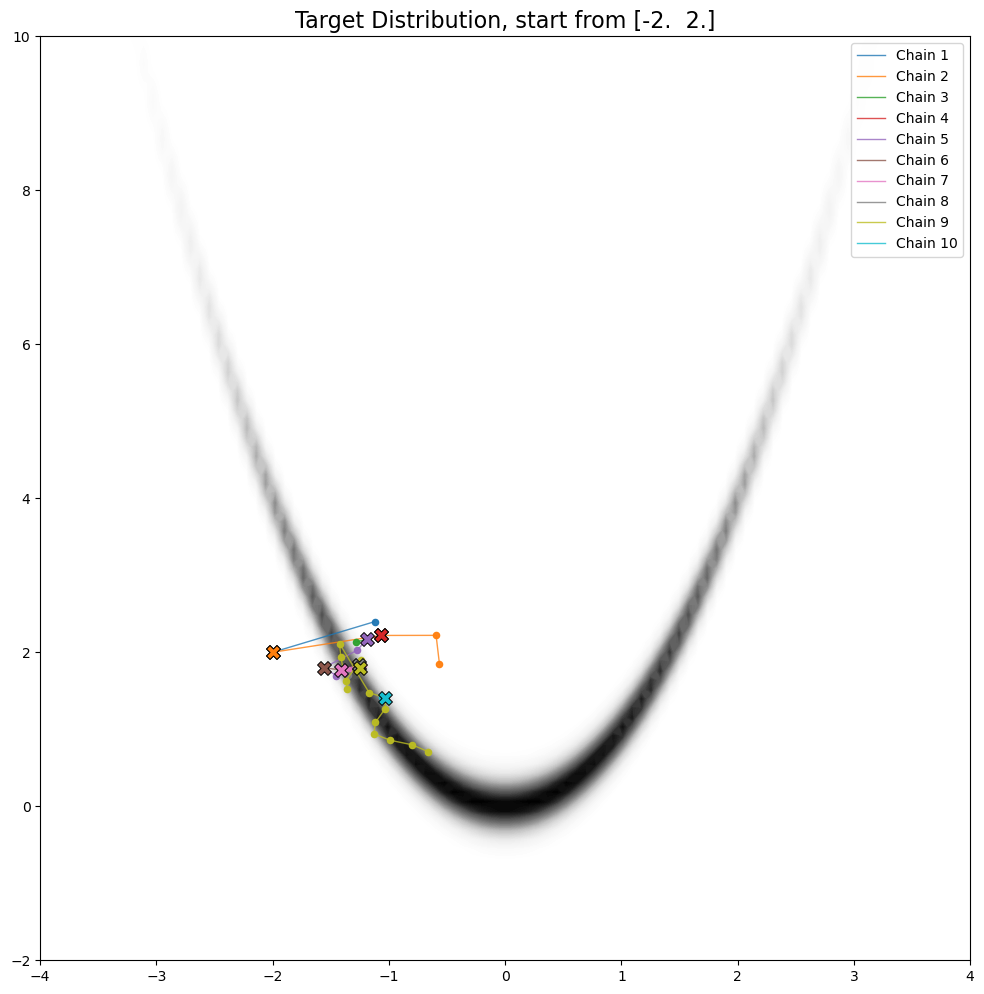

In [65]:
theta0 = np.array([-2, 2])  # a much weaker ability to cover both part of the banana density (sometimes only half part)
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_banana, all_positions, x_low, x_high, y_low, y_high)

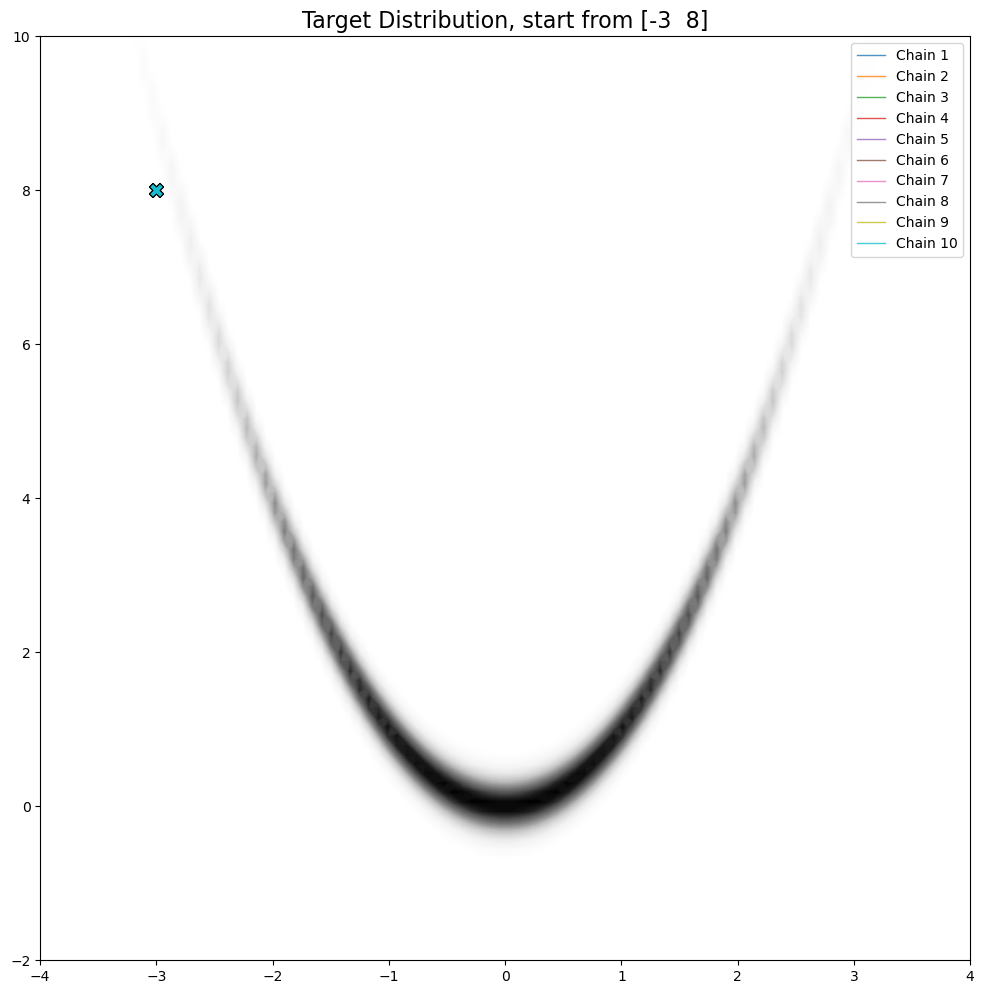

In [66]:
theta0 = np.array([-3, 8])  # stopping criteria very easy to meet and hardly move - stick on the starting point
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_banana, all_positions, x_low, x_high, y_low, y_high)

Investigate how many samples are needed until to move to a sensible place to cover the whole distribution later. 

In [67]:
def sample_size_plot(log_joint_density_component_form, theta0, sampler, 
                     x_low, x_high, y_low, y_high,
                     sample_size_list=[10, 100, 1000, int(1e4), int(1e5)]):

    # Precompute contour grid for the target density once
    x_bb = np.linspace(x_low, x_high, 100)
    y_bb = np.linspace(y_low, y_high, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_joint_density_component_form(X_bb, Y_bb))

    # create a single figure with 2 rows x 3 cols
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes_flat = axes.ravel()

    # Panel 0: target contour
    ax0 = axes_flat[0]
    cf = ax0.contourf(X_bb, Y_bb, Z_bb, levels=100, cmap='RdBu')
    ax0.set_title('Target Distribution')

    # For remaining panels: run sampler and plot hist2d
    burn_in = 0

    for i, num_samples in enumerate(sample_size_list):
        # panel index (1,..., 5)
        ax = axes_flat[i + 1]

        # run sampler
        samples, _, _ = sampler.NUTS_sample(theta0, num_samples, M, monitor_results=False)

        # extract samples
        x = samples[burn_in:, 0]
        y = samples[burn_in:, 1]

        # 2D histogram
        h = ax.hist2d(x, y, bins=100, range=[[x_low, x_high], [y_low, y_high]], cmap='RdBu', density=True)
        ax.set_title(f'Naive NUTS: {num_samples:,} iterations')

    # tighten layout and show
    plt.tight_layout()
    plt.show()

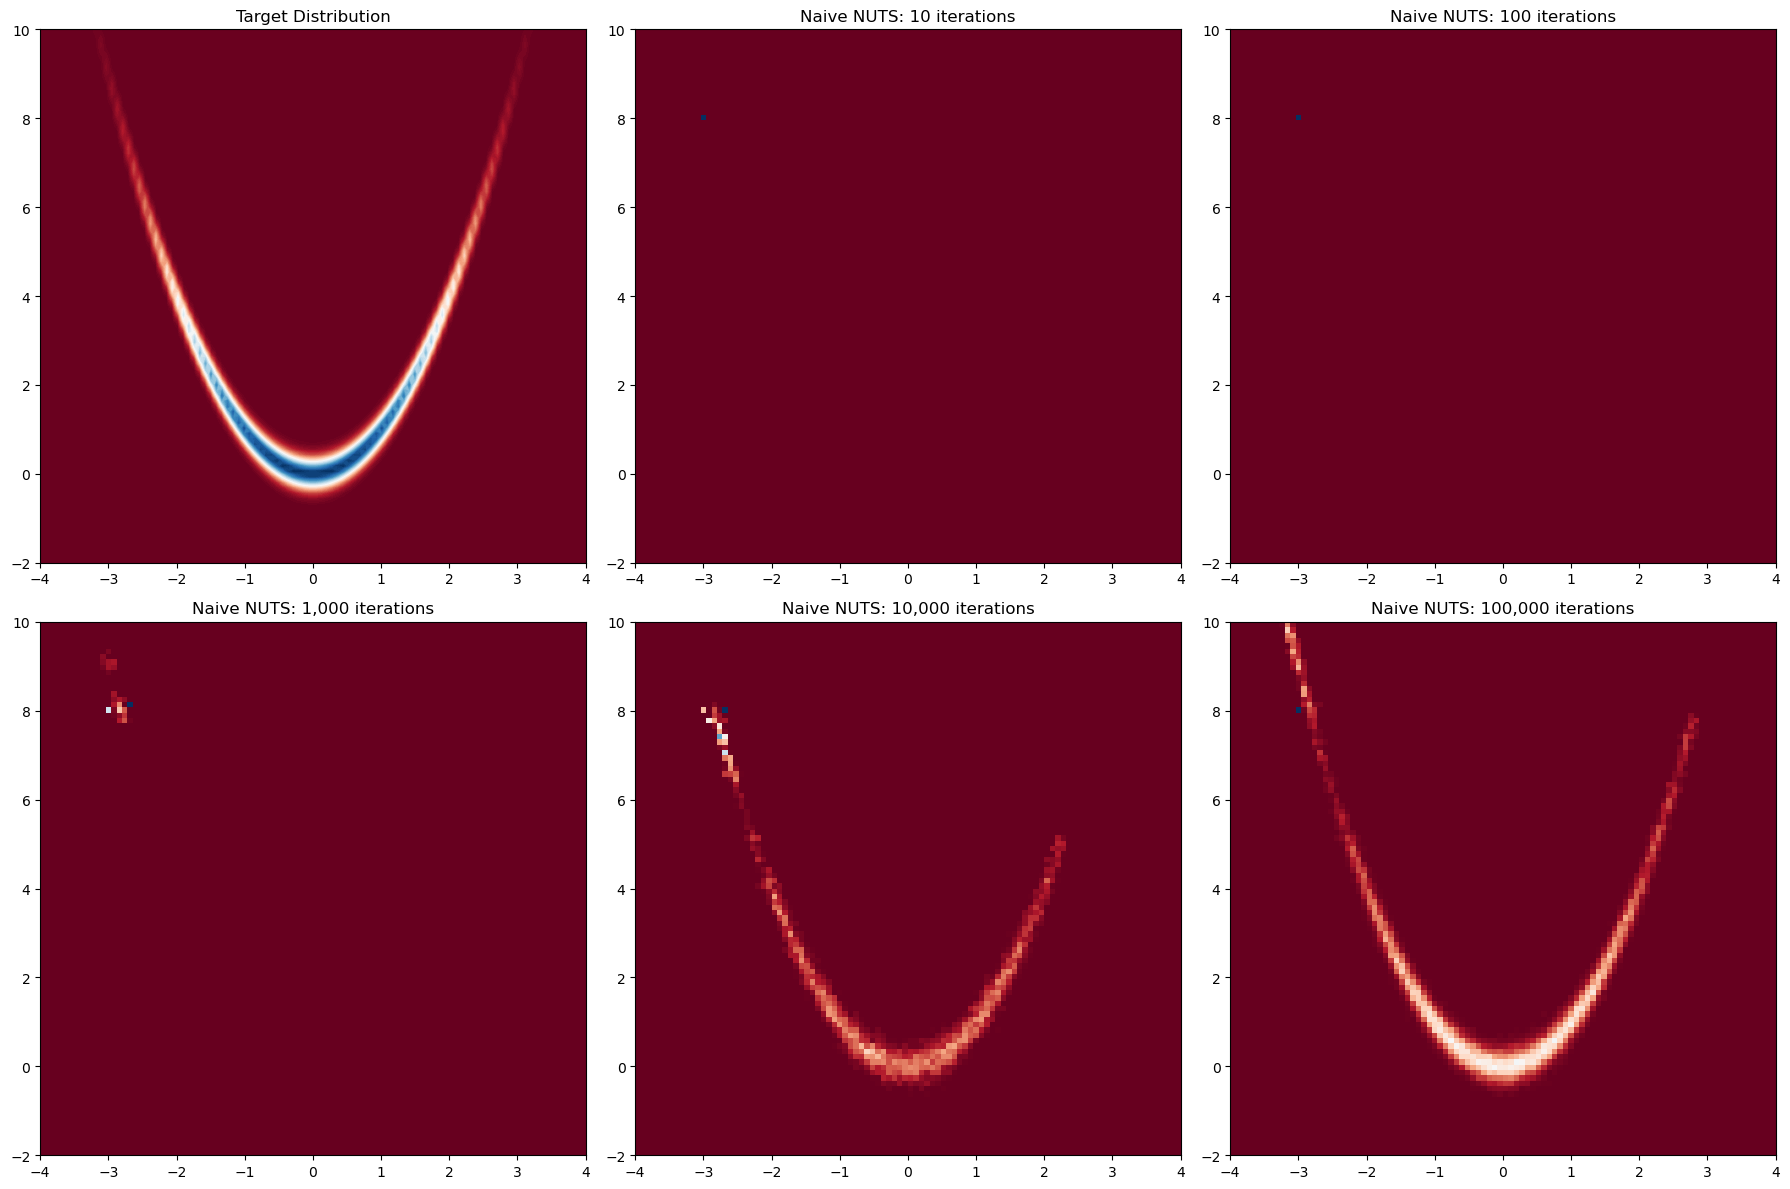

In [68]:
theta0 = np.array([-3, 8])
sampler = naiveNUTS(example_log_prob, example_grad_log_prob)  # naive NUTS on banana density

sample_size_plot(log_banana, theta0, sampler, x_low=-4, x_high=4, y_low=-2, y_high=10)

**Case 2: standard Gaussian density.**

In [69]:
def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

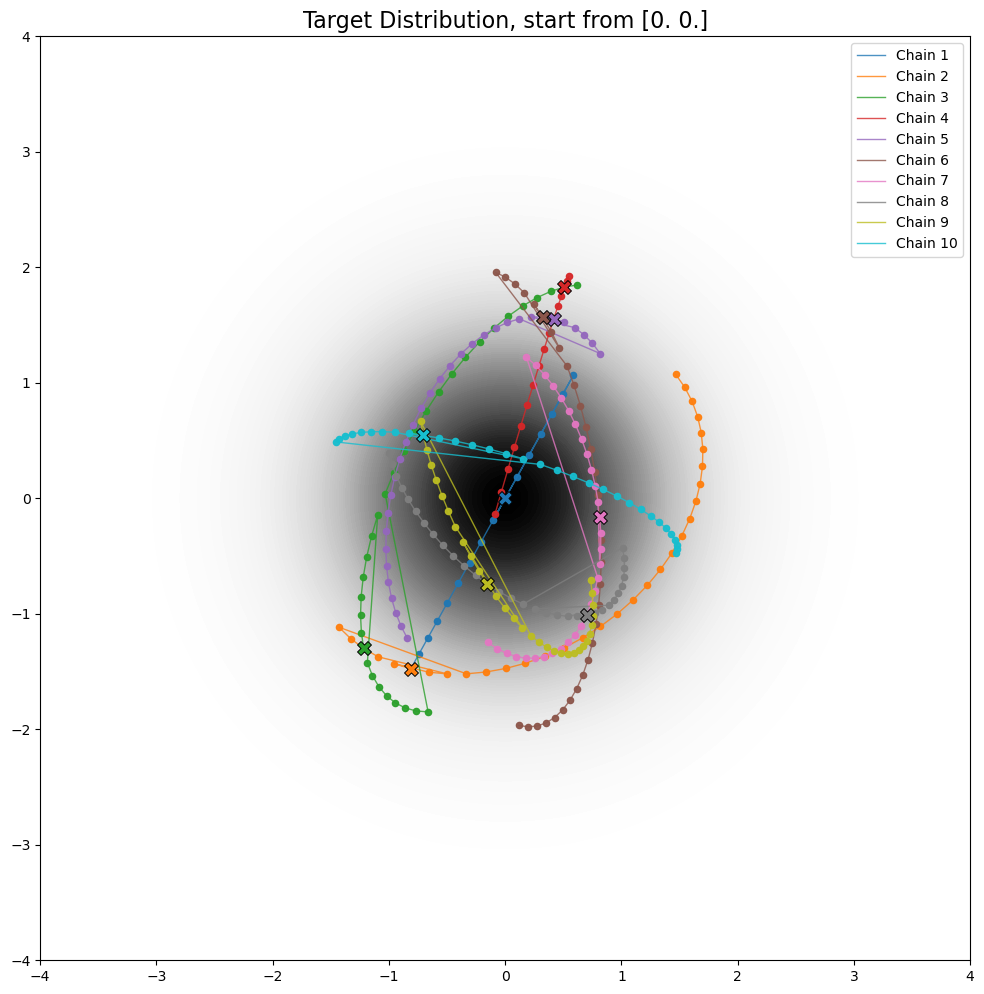

In [70]:
theta0 = np.array([0, 0])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

# Plot range for standard Gaussian
x_low, x_high = -4, 4
y_low, y_high = -4, 4

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_standard_normal, all_positions, x_low, x_high, y_low, y_high)

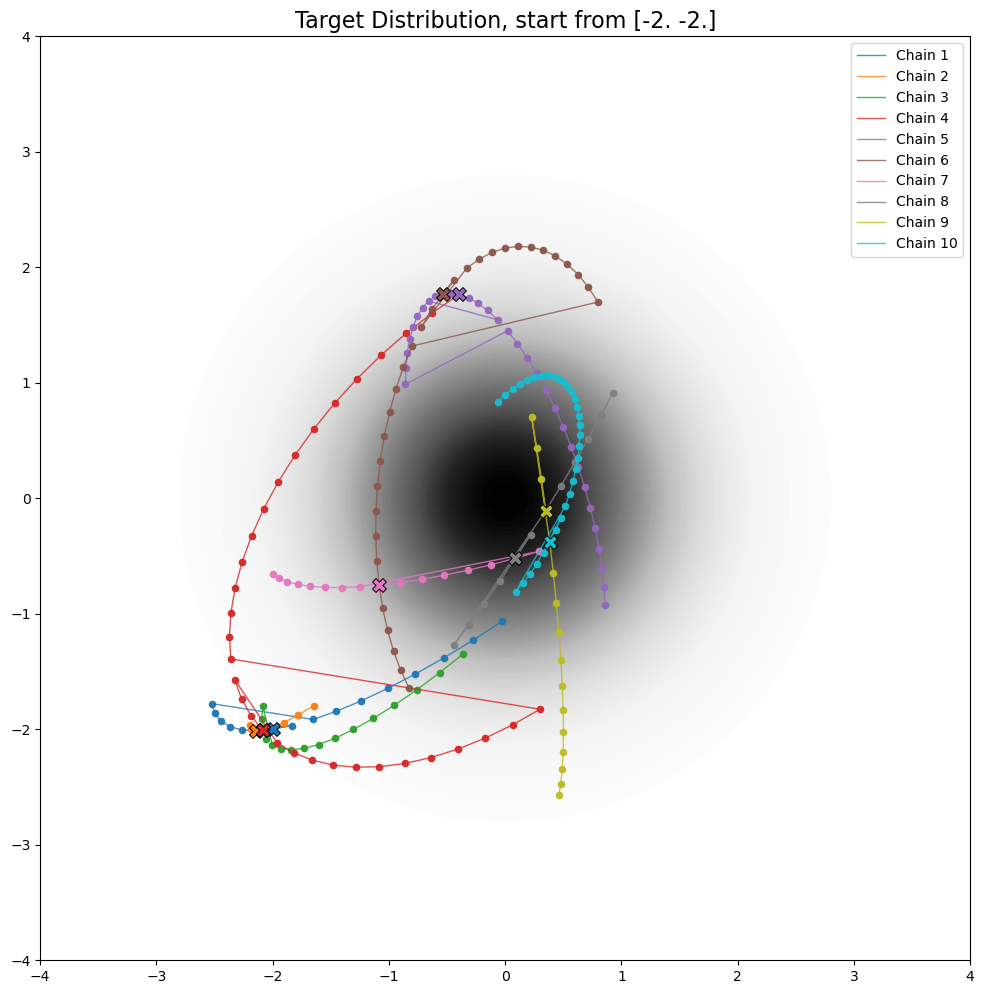

In [71]:
theta0 = np.array([-2, -2])  # always cover most part of the target distribution for the first 10 iterations
all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_standard_normal, all_positions, x_low, x_high, y_low, y_high)

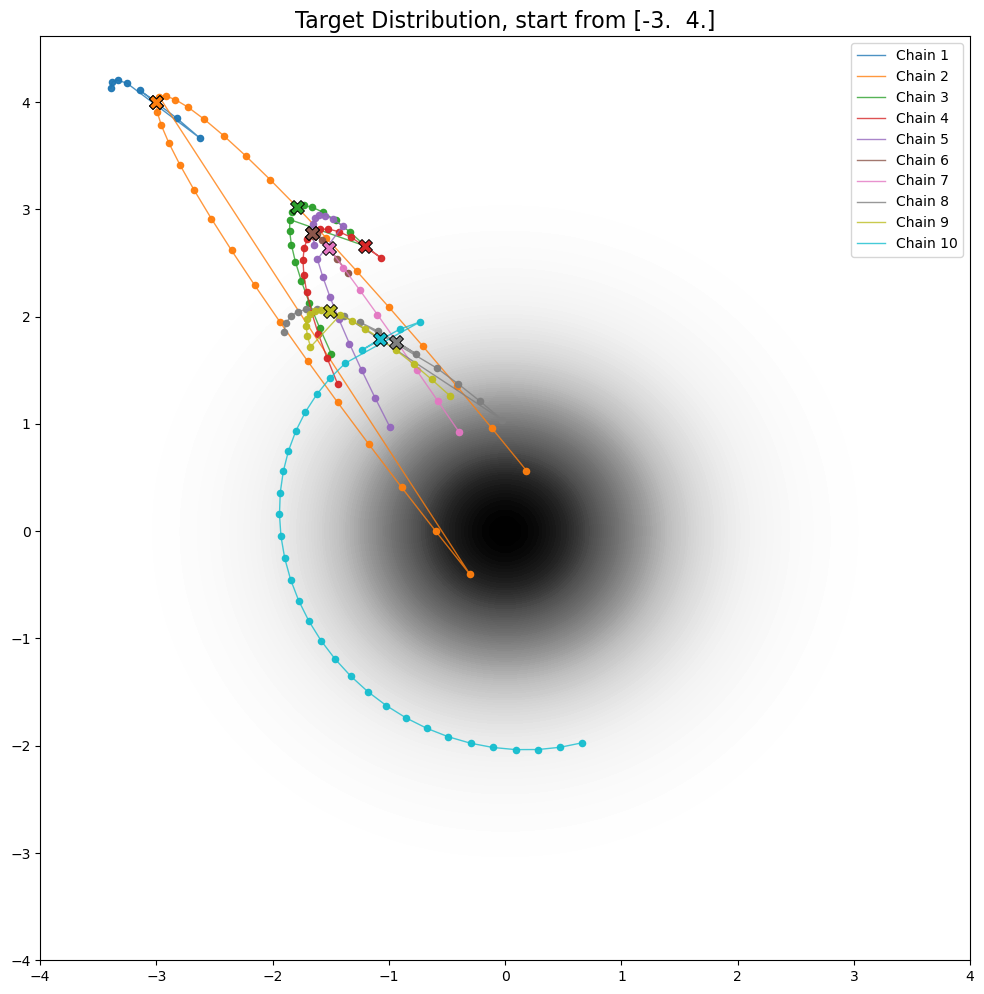

In [72]:
theta0 = np.array([-3, 4])  # always cover most part of the target distribution for the first 10 iterations
all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_standard_normal, all_positions, x_low, x_high, y_low, y_high)

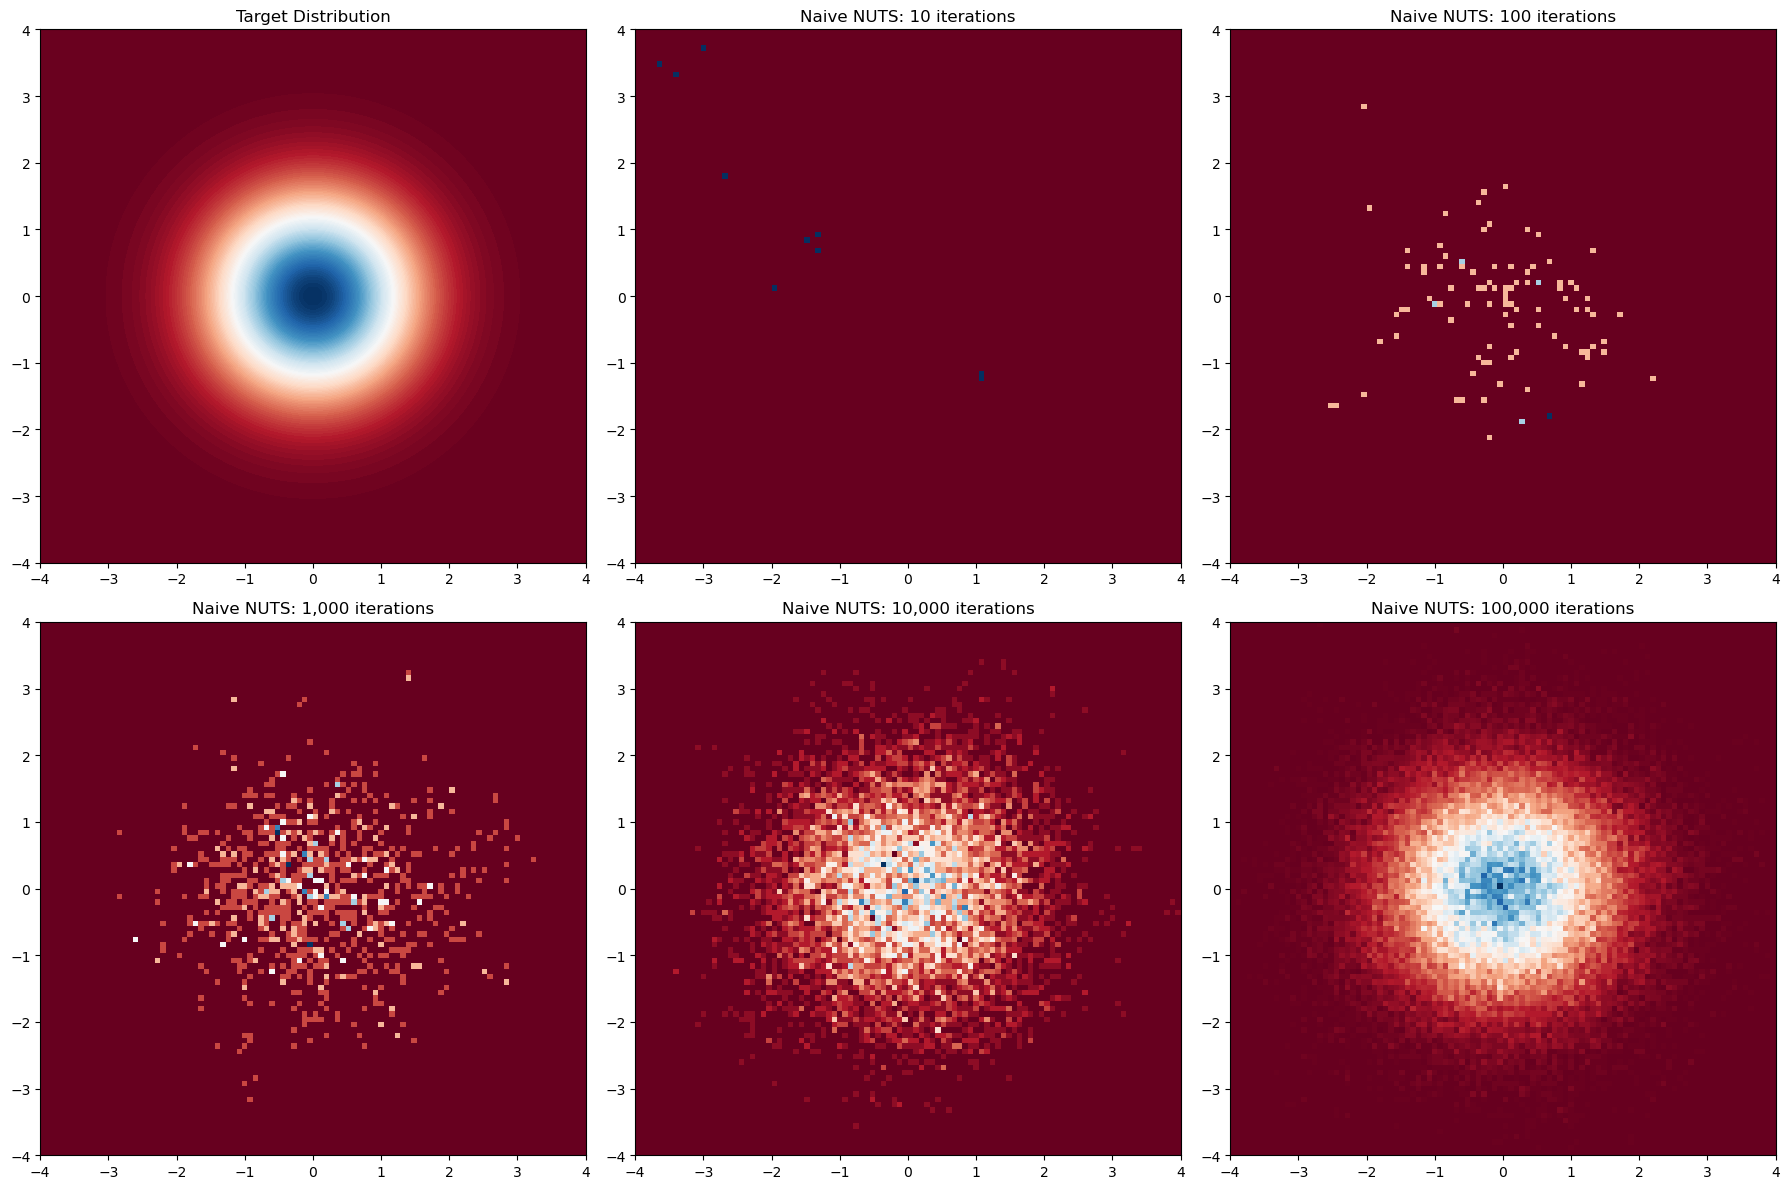

In [73]:
theta0 = np.array([-3, 4])
sampler = naiveNUTS(example_log_prob, example_grad_log_prob)  # naive NUTS on standard Gaussian density

sample_size_plot(log_standard_normal, theta0, sampler, x_low, x_high, y_low, y_high)

**Case 3: Stretched Gaussian (with uncorrelated component $\rho=0$) but with huge difference in component variance.**

In [74]:
def example_log_prob(theta):
    x, y = theta
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    partial_x = (1 - x)/0.005**2
    partial_y = -(y + 1)/3**2
    return np.array([partial_x, partial_y])

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_extreme_stretch_normal(x, y):
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

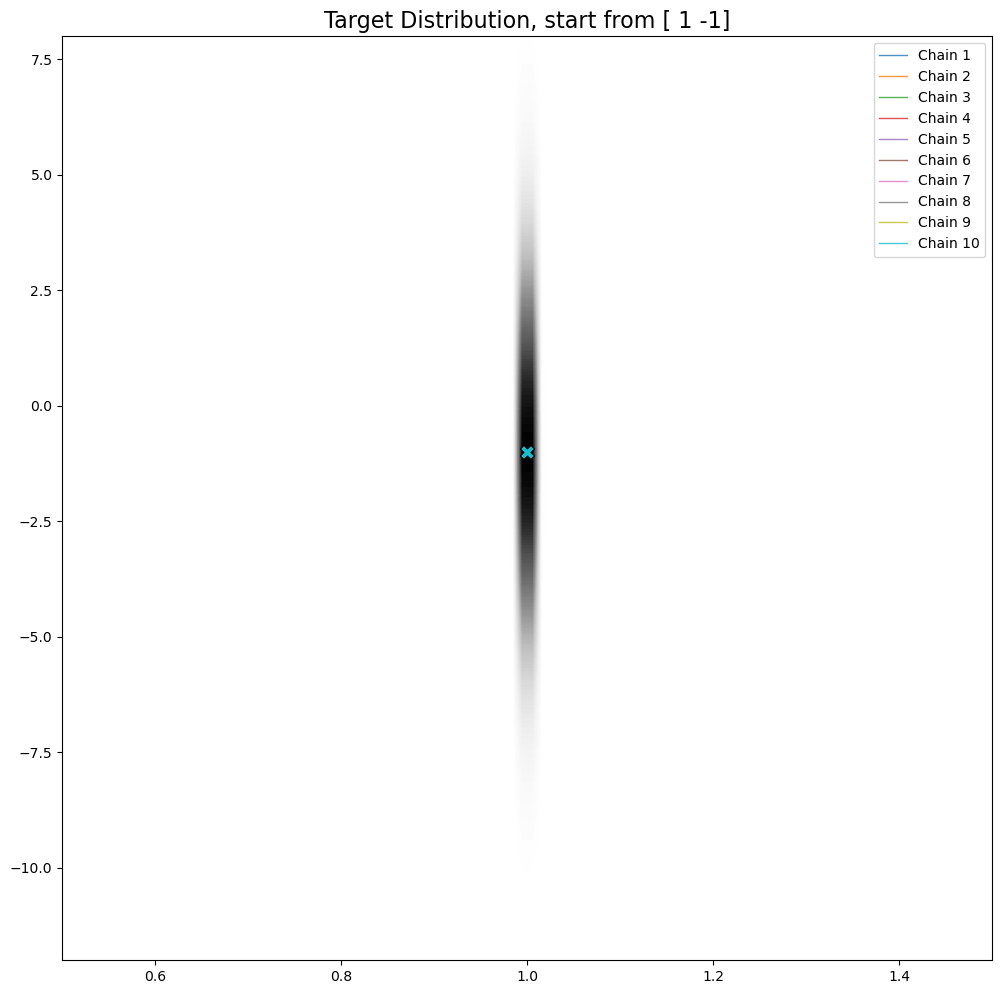

In [76]:
theta0 = np.array([1, -1])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

# Plot range for standard Gaussian
x_low, x_high = 0.5, 1.5
y_low, y_high = -12, 8

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory(log_extreme_stretch_normal, all_positions, x_low, x_high, y_low, y_high)

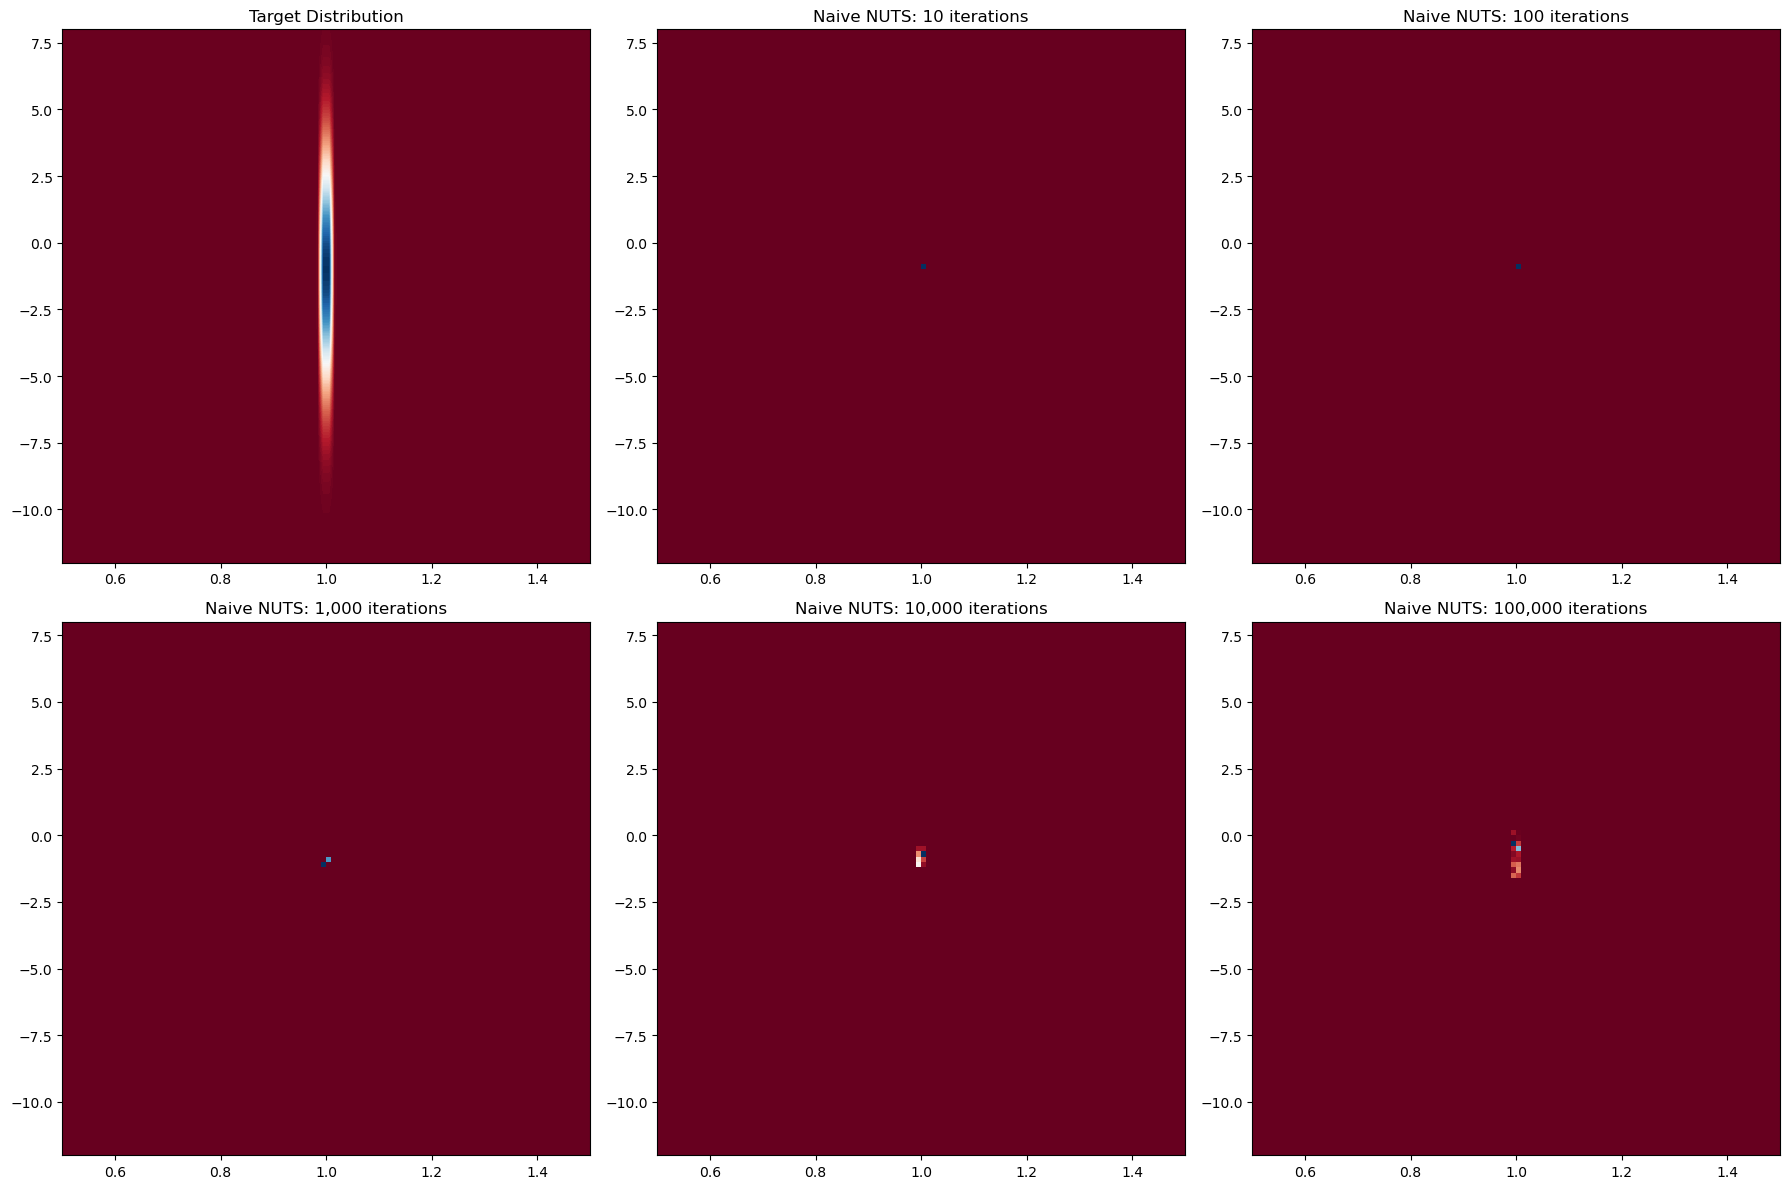

In [77]:
theta0 = np.array([1, -1])
sampler = naiveNUTS(example_log_prob, example_grad_log_prob)  # naive NUTS on standard Gaussian density

sample_size_plot(log_extreme_stretch_normal, theta0, sampler, x_low, x_high, y_low, y_high)

**Case 4: some other weird but extreme distributions.**

In [78]:
def angle_justification(theta):
    """
    Justify whether the given angle lie in the accepted region,
    as the complement of (pi/4, pi/2) and (pi, 5*pi/4).

    Args:
        theta (np.ndarray): the angle(s) for justification.
    Return:
        (bool) results showing whether the angle lies in the acceptable region or not.
    """

    # Angle theta assumed in [0, 2*pi), return True if in A
    a1 = (theta > np.pi/4) & (theta < np.pi/2)  # rejected region 1
    a2 = (theta > np.pi) & (theta < 5 * np.pi/4)  # rejected region 2
    # We will reject once the angle lie in either a1 or a2
    # hence we will accept its negation, using bitwise form
    return ~(a1 | a2)


# log-density function component form
def log_trunc_ring(x, y):
    # Transform into the polar form
    r = np.sqrt(x**2 + y**2)
    # robust angle in [0, 2*pi)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)

    # Define the accepted region
    accept_region = (r >= 1.0) & (r <= 2.0) & angle_justification(theta)

    log_prob_val = np.full_like(r, fill_value=-np.inf)  # initialise, default value as -np.inf for rejected regions
    if np.any(accept_region):
        log_prob_val[accept_region] = np.log(2/(3*np.pi)) - np.log(r[accept_region])

    return log_prob_val


def example_log_prob(theta):
    x, y = theta
    log_prob_val = log_trunc_ring(x, y)

    return log_prob_val


def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    
    # Transform into the polar form
    r = np.sqrt(x**2 + y**2)
    # robust angle in [0, 2*pi)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)

    # Define the accepted region
    accept_region = (r >= 1.0) & (r <= 2.0) & angle_justification(theta)

    if accept_region:
        # Compute the partial derivatives
        partial_x = -np.log(2/(3*np.pi)) * x * r**(-3)
        partial_y = -np.log(2/(3*np.pi)) * y * r**(-3)
    else:
        partial_x, partial_y = 0, 0

    return np.array([partial_x, partial_y])

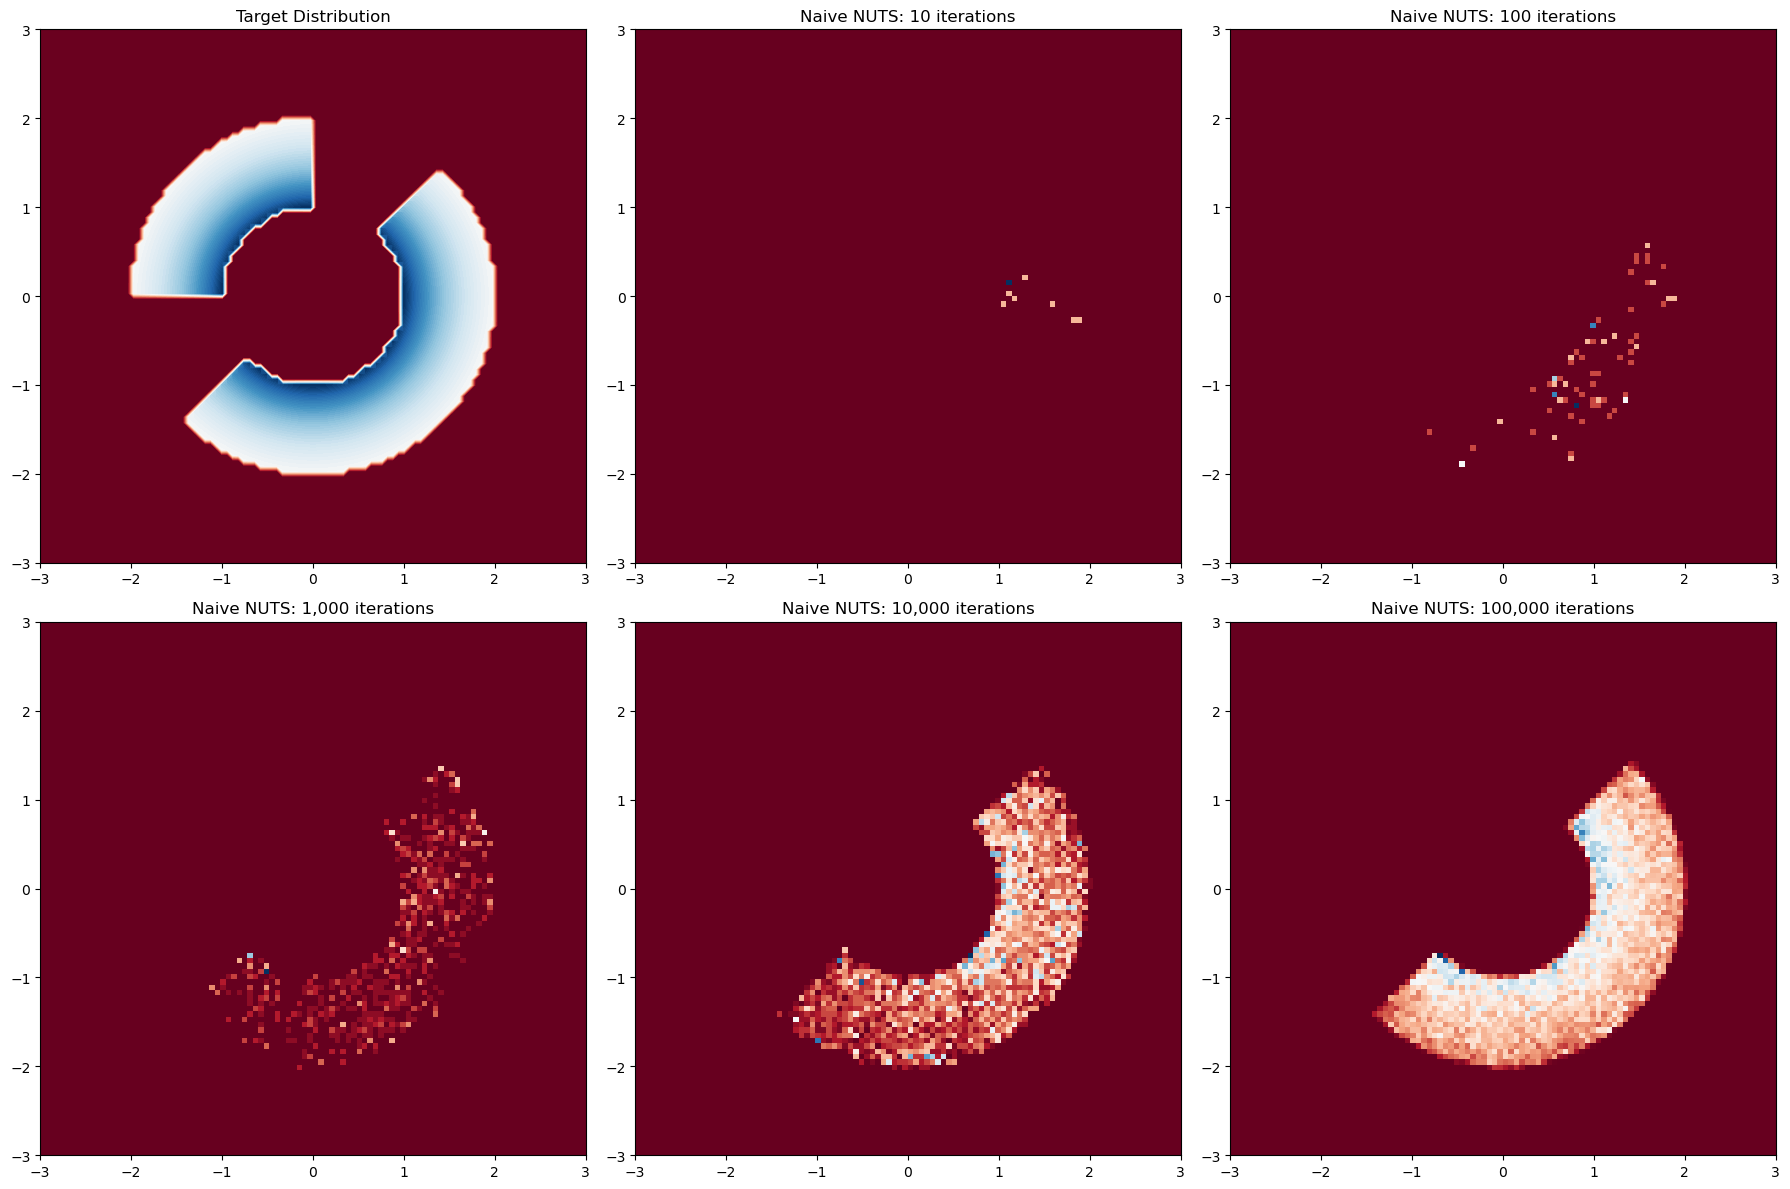

In [79]:
theta0 = np.array([1, -1])
sampler = naiveNUTS(example_log_prob, example_grad_log_prob)  # naive NUTS on standard Gaussian density

sample_size_plot(log_trunc_ring, theta0, sampler, x_low=-3, x_high=3, y_low=-3, y_high=3)

# Section 4

1. Heatmap of generated samples.

2. Bar chart of cardinality of $C$ - the larger, the longer the chain generated by binary tree.

3. Histogram of (furtherest) distance of $C$ - the larger distance, the longer movement/chain. 

The error 'ValueError: Contour levels must be increasing' occurs when the KDE computation results in non-monotonic values, often due to:

1. Too few data points - the KDE can't properly estimate density

2. Very concentrated data - all points are nearly identical

3. Numerical issues with the bandwidth estimation

In [ ]:
import seaborn as sns

def naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler, 
                           num_samples, num_samples_adapt, target_accept_rate, 
                           num_iter, theta0, M,
                           log_joint_density_component_form,
                           x_low, x_high, y_low, y_high, adaption=True):
    """Generate the heatmap plot for a instant jump/sampling process from the initial theta0 for a naive NUTS.
    Args:
        adaptive_nuts_sampler: the adaptive NUTS sampler from class adaptiveNUTS.
        naive_nuts_sampler: the naive NUTS sampler defined from class naiveNUTS, using certain log_joint density and its gradient.
        num_samples (int): Number of samples for adaptive NUTS to generate.
        num_samples_adapt (int): Number of samples for the adaptation process of stepsize.
        target_accept_rate (float): Target acceptance rate for dual averaging, denoted as delta in Hoffman's paper.
        num_iter (int): number of iterations for the instant jumps (different from num_samples).
        theta0 (np.ndarray): initial position vector.
        M (np.ndarray): the mass matrix for NUTS sampling.
        log_joint_density_component_form (Callable): log joint density in (2D) component form.
        x_low, x_high (floats): range for the plot in x-direction.
        y_low, y_high (floats): range for the plot in y-direction.
        adaption (bool): control whether we first run the adaptive NUTS to achieve an adapted stepsize. Default to True.
    """

    # We first carry the adaptive NUTS if necessary to achieve an adapted stepsize
    if adaption:
        _, eps_list, _, _, _ = adaptive_nuts_sampler.NUTS_sample(
            theta0, num_samples, num_samples_adapt, target_accept_rate, M, monitor_results=False)
        eps = eps_list[-1]  # take the final adapted stepsize
        print(f'The adapted stepsize we use is {eps}.')
    else:
        eps = 0.1  # set a default stepsize if no adaption
        print(f'If no adaption, then just use default stepsize {eps}.')

    # Now we run the naive NUTS by proposing just one jump with this adapted stepsize, with the starting point theta0
    # We repeat this process for num_iter times to get num_iter possible 'instant jumps' from theta0
    instant_jump_sample = []  # initialise
    for _ in range(num_iter):
        samples, _, _ = naive_nuts_sampler.NUTS_sample(theta0, 1, M, eps, monitor_results=False)
        instant_jump_sample.append(samples.reshape(-1))

    # Convert to numpy array for manipulation
    instant_jump_sample = np.array(instant_jump_sample)

    # Extract x and y coordinates for position chain
    x_samples = instant_jump_sample[:, 0]
    y_samples = instant_jump_sample[:, 1]

    # Check if we have enough unique points for KDE
    unique_points = np.unique(instant_jump_sample)
    if len(unique_points) < 0.01 * num_iter:
        print(f'Warning: Only {len(unique_points)} unique points. Using scatter plot instead of KDE.')
        use_kde = False
    else:
        use_kde = True

    # Create figure using KDE
    plt.figure(figsize=(10, 8))

    # Draw contour background
    x_bb = np.linspace(x_low, x_high, 100)
    y_bb = np.linspace(y_low, y_high, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_joint_density_component_form(X_bb, Y_bb))

    # Contour background
    contour = plt.contour(X_bb, Y_bb, Z_bb, levels=10, alpha=0.5, linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2f')

    # Plot the samples
    if use_kde:
        # Try seaborn KDE as heatmap with error handling
        sns.kdeplot(x=x_samples, y=y_samples, fill=True, 
                    thresh=0.05, alpha=0.8, cmap='plasma',
                    cbar=True, cbar_kws={'label': 'Sample Density'},
                    warn_singular=False)

    if not use_kde:
        # Just show scatter plot for very few points
        plt.scatter(x_samples, y_samples, alpha=0.7, s=50, 
                    color='purple', edgecolors='white', linewidth=1)
    
    plt.xlabel('Position direction 1')
    plt.ylabel('Position direction 2')
    plt.title(f'KDE of {num_iter} instant jumps from {theta0}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

**Case 1: standard normal density**

The adapted stepsize we used for later naive NUTS is 1.410252701060217.


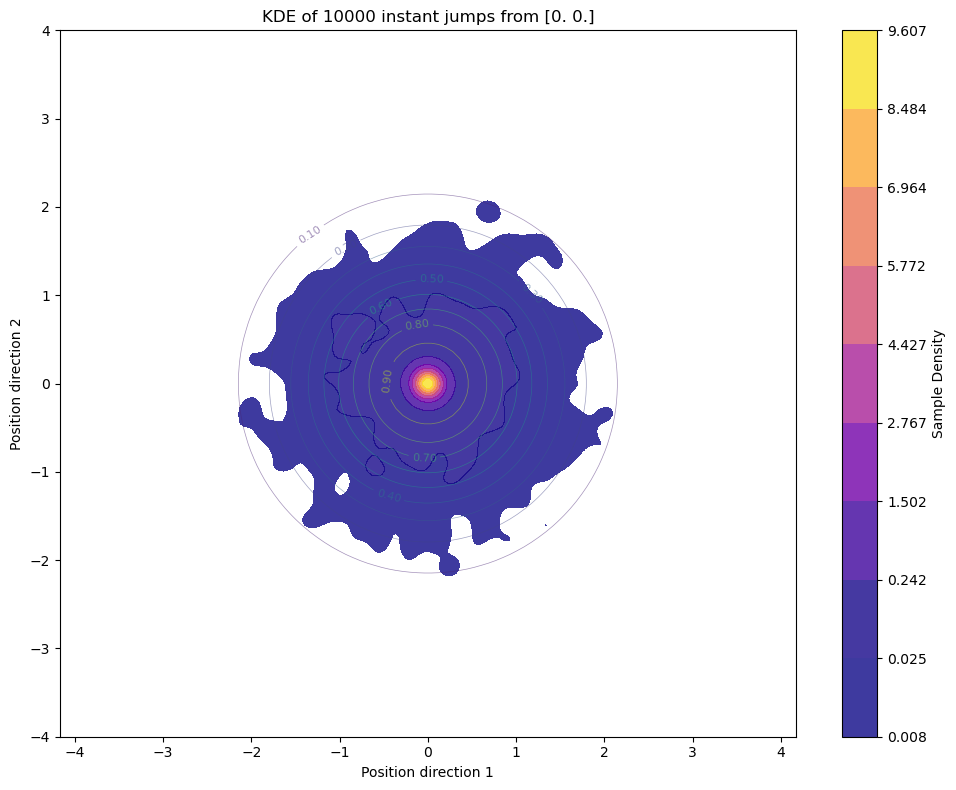

In [44]:
def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# still should first run the adaptive scheme to ensure the jump...
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary
num_samples_adapt = 50000  # number of samples for adaptation
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

# Define the samplers and related quantities
adaptive_nuts_sampler = adaptiveNUTS(example_log_prob, example_grad_log_prob)
naive_nuts_sampler = naiveNUTS(example_log_prob, example_grad_log_prob)
num_iter = 10000
x_low, x_high = -4, 4
y_low, y_high = -4, 4

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_standard_normal,
                       x_low, x_high, y_low, y_high)


The adapted stepsize we used for later naive NUTS is 1.5240893212583937.


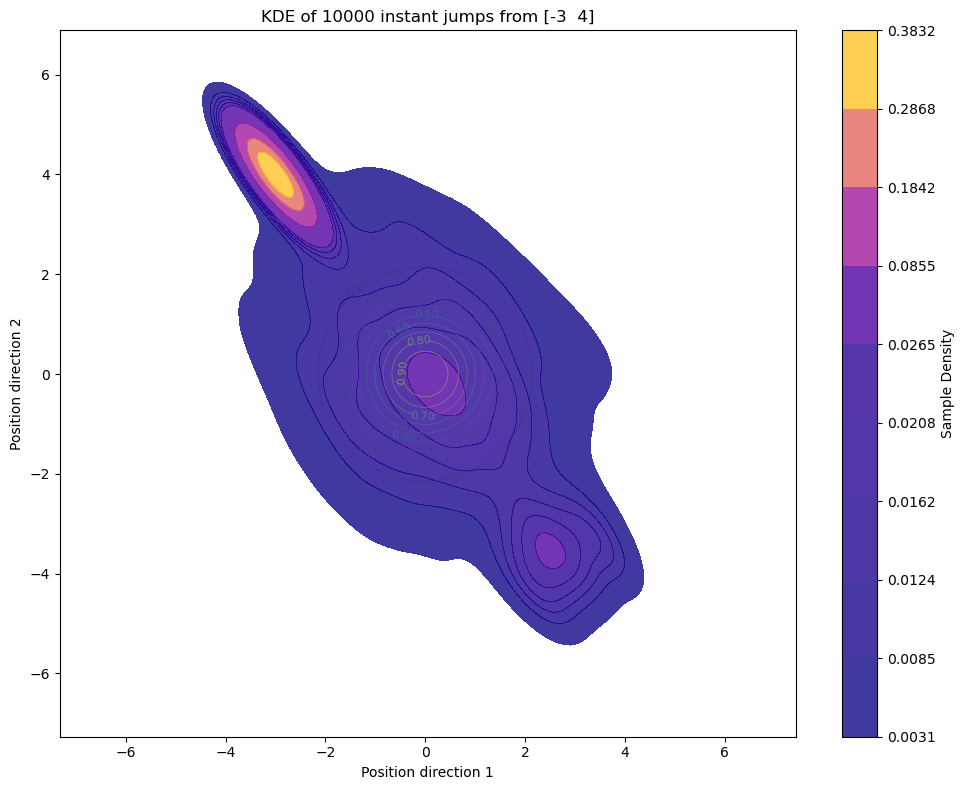

In [45]:
# Try a different starting position
theta0 = np.array([-3, 4])

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_standard_normal,
                       x_low, x_high, y_low, y_high)

**Case 2: (sharp) banana density**

The adapted stepsize we used for later naive NUTS is 0.13639094298847979.


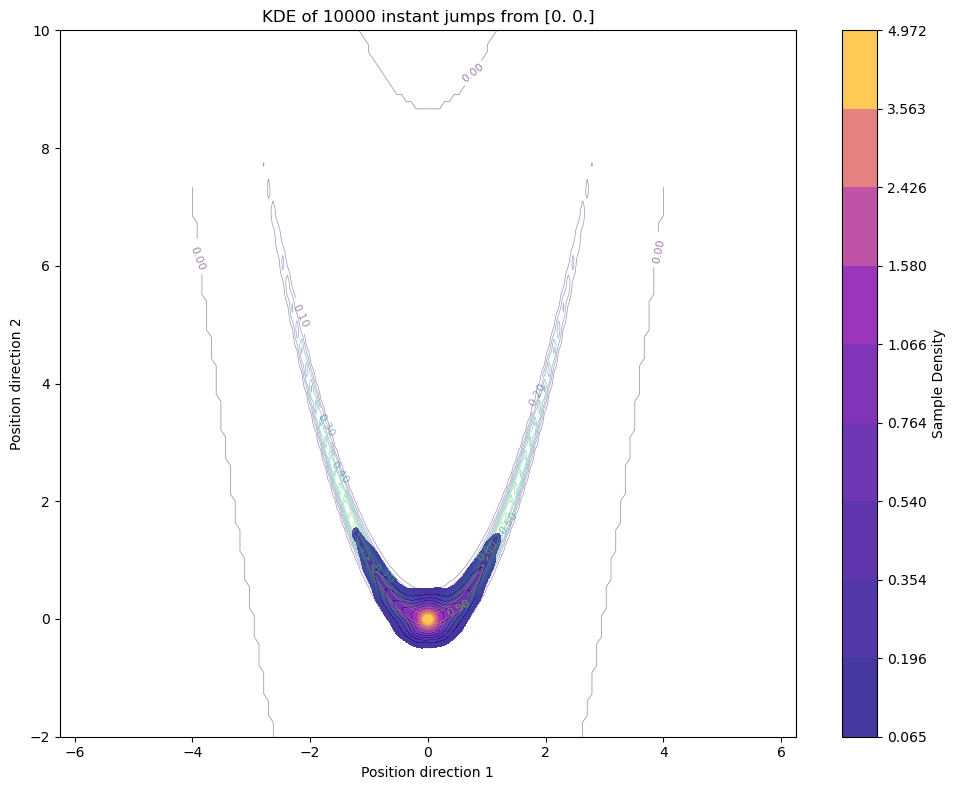

In [46]:
def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 30 - y**2 / 30 - 10 * (y - x**2)**2

# still should first run the adaptive scheme to ensure the jump...
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary
num_samples_adapt = 50000  # number of samples for adaptation
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

# Define the samplers and related quantities
adaptive_nuts_sampler = adaptiveNUTS(example_log_prob, example_grad_log_prob)
naive_nuts_sampler = naiveNUTS(example_log_prob, example_grad_log_prob)
num_iter = 10000
x_low, x_high = -4, 4
y_low, y_high = -2, 10

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_banana,
                       x_low, x_high, y_low, y_high)

The adapted stepsize we used for later naive NUTS is 0.168264903705807.


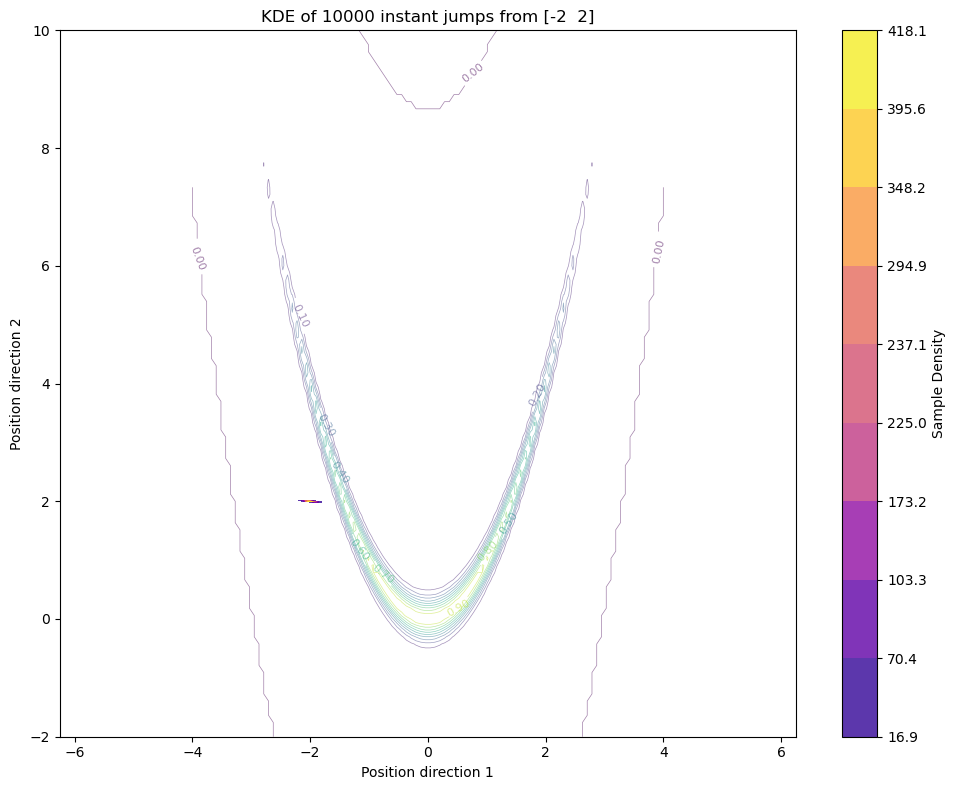

In [49]:
# Try a different starting position
theta0 = np.array([-2, 2])

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_banana,
                       x_low, x_high, y_low, y_high)

If no adaption, then just use default stepsize 0.1.


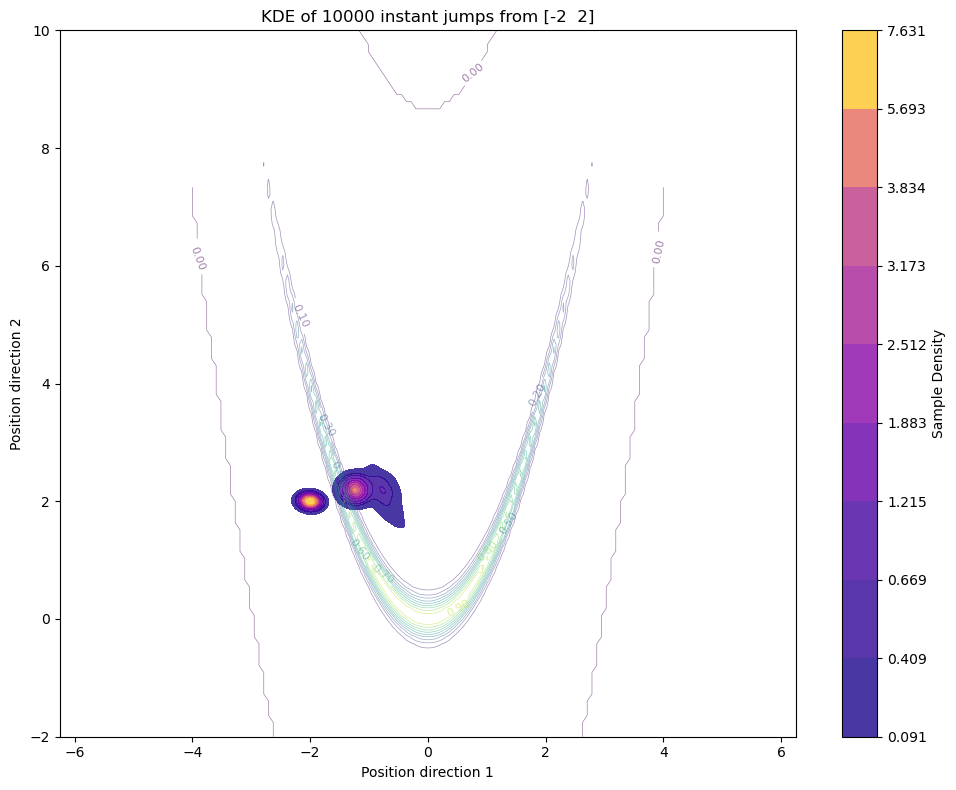

In [48]:
# without adaption (so stepsize=0.1)
theta0 = np.array([-2, 2])

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_banana,
                       x_low, x_high, y_low, y_high, adaption=False)

**Case 3: Stretched Gaussian (with uncorrelated component $\rho=0$) but with huge difference in component variance.**

In [50]:
def example_log_prob(theta):
    x, y = theta
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    partial_x = (1 - x)/0.005**2
    partial_y = -(y + 1)/3**2
    return np.array([partial_x, partial_y])

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_extreme_stretch_normal(x, y):
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

# still should first run the adaptive scheme to ensure the jump...
theta0 = np.array([1.0, -1.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary
num_samples_adapt = 50000  # number of samples for adaptation
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

# Define the samplers and related quantities
adaptive_nuts_sampler = adaptiveNUTS(example_log_prob, example_grad_log_prob)
naive_nuts_sampler = naiveNUTS(example_log_prob, example_grad_log_prob)
num_iter = 10000
x_low, x_high = 0.5, 1.5
y_low, y_high = -12, 8

naiveNUTS_heatmap_plot(adaptive_nuts_sampler, naive_nuts_sampler,
                       num_samples, num_samples_adapt, target_accept_rate,
                       num_iter, theta0, M, log_extreme_stretch_normal,
                       x_low, x_high, y_low, y_high)

KeyboardInterrupt: 

# Potential research directions:

1. Curse of dimensionality: as parameter dimension increases, even small jump for each component would result a overall large jump for the whole position vector, meaning that we will need smaller stepsizes to control the jump size so the chain would not stop too early, whereas smaller stepsize would result slower convergence and higher sampling cost. Can we propose methods, like resampling in particle filters, to reduce this curse of dimensionality so we can still achieve good sampling while with larger stepsizes?

2. Dataset: can NUTS also works well for Bayesian model on imbalanced datasets? It is trivial that imbalanced datasets would result very skewed likelihood and severely affect the shape of the posterior to be somewhat skewed and concentrated as well.

3. This might be related to point 2, that we may pick some very skewed/concentrated distributions and see the sampling behaviour for some finite number of build tree processes: are the possible position-momentum pairs given lie in just a small proportion of the distribution? If so, how long will it take for the initial position to move to another proportion of the target distribution, and finally cover the whole distribution?  

4. Ergodicity: this is more theory based - can we write the chain distribution at each time for NUTS and investigate the ergodicity for the chain, also the mixing time along with the total variation distance or Wasserstein distance? 